In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
from VisUtils import *
import pandas as pd
import numpy as np

In [2]:
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition'] 
nek_list = ["2", "3", "5", "9"]
nektype = ['binding','inhibition']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
model_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
RF_types = ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=2)
category_order = ['TP', 'TN', 'FP', 'FN']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
k=7
prob_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/RF/RF_results/proba_dfs/'
col_names = ['prediction_type', 'ADdist', 'model_type']
result_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/RF/RF_results/'
# result_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/RF/RF_grid_search/rf_results/'
# pickle_path ='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/RF/RF_grid_search/rf_results'
# prob_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/RF/RF_grid_search/rf_results/proba_dfs_GS/'

In [3]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis-train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

# SUBPLOTS

In [4]:
# pred_palette = {'TP':'#1B512D', 'FP':'#B1CF5F', 'TN': '#EBA6A9', 'FN': '#880044'}
pred_markers = {'TP': 'o','TN': 's', 'FP': '^', 'FN': 'D'}
pred_sizes = {'TP': 100, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}

In [7]:

def RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax):
    predictions = df['prediction']
    ad_dist=df['ADdist']
    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]

    data = {'std of probabilities': np.concatenate([tp_std1,tn_std0,fp_std1, fn_std1]),
        'prediction_type': ['TP'] * len(true_pos) + ['TN'] * len(true_neg) + ['FP'] * len(false_pos) + ['FN'] * len(false_neg),
        'ADdist': np.concatenate([tp_ad, tn_ad, fp_ad,fn_ad]) 
    }
    data = pd.DataFrame(data)
    sizes = data['prediction_type'].map(pred_sizes)
    # markers=pred_markers, style='prediction_type'
    sns.scatterplot(data=data, x='ADdist', y='std of probabilities', hue='prediction_type', palette=pred_palette, ax=ax)
    ax.set_title(title)
    ax.get_legend().remove()
    ax.set_xlabel('ADdist', fontsize=15)
    ax.set_ylabel('std of probability', fontsize=15)
    ax.set_ylim(-0.01, 0.51)
    ax.set_xlim(-.30,12) 
    
    # ax.get_legend().remove()



NEK2 moe scaled [271, 0, 12, 0]
NEK2 moe UNDER [191, 80, 6, 6]
NEK2 moe SMOTE [268, 3, 9, 3]
NEK2 moe ADASYN [267, 4, 7, 5]
NEK2 mfp scaled [270, 1, 9, 3]
NEK2 mfp UNDER [153, 118, 4, 8]


KeyboardInterrupt: 

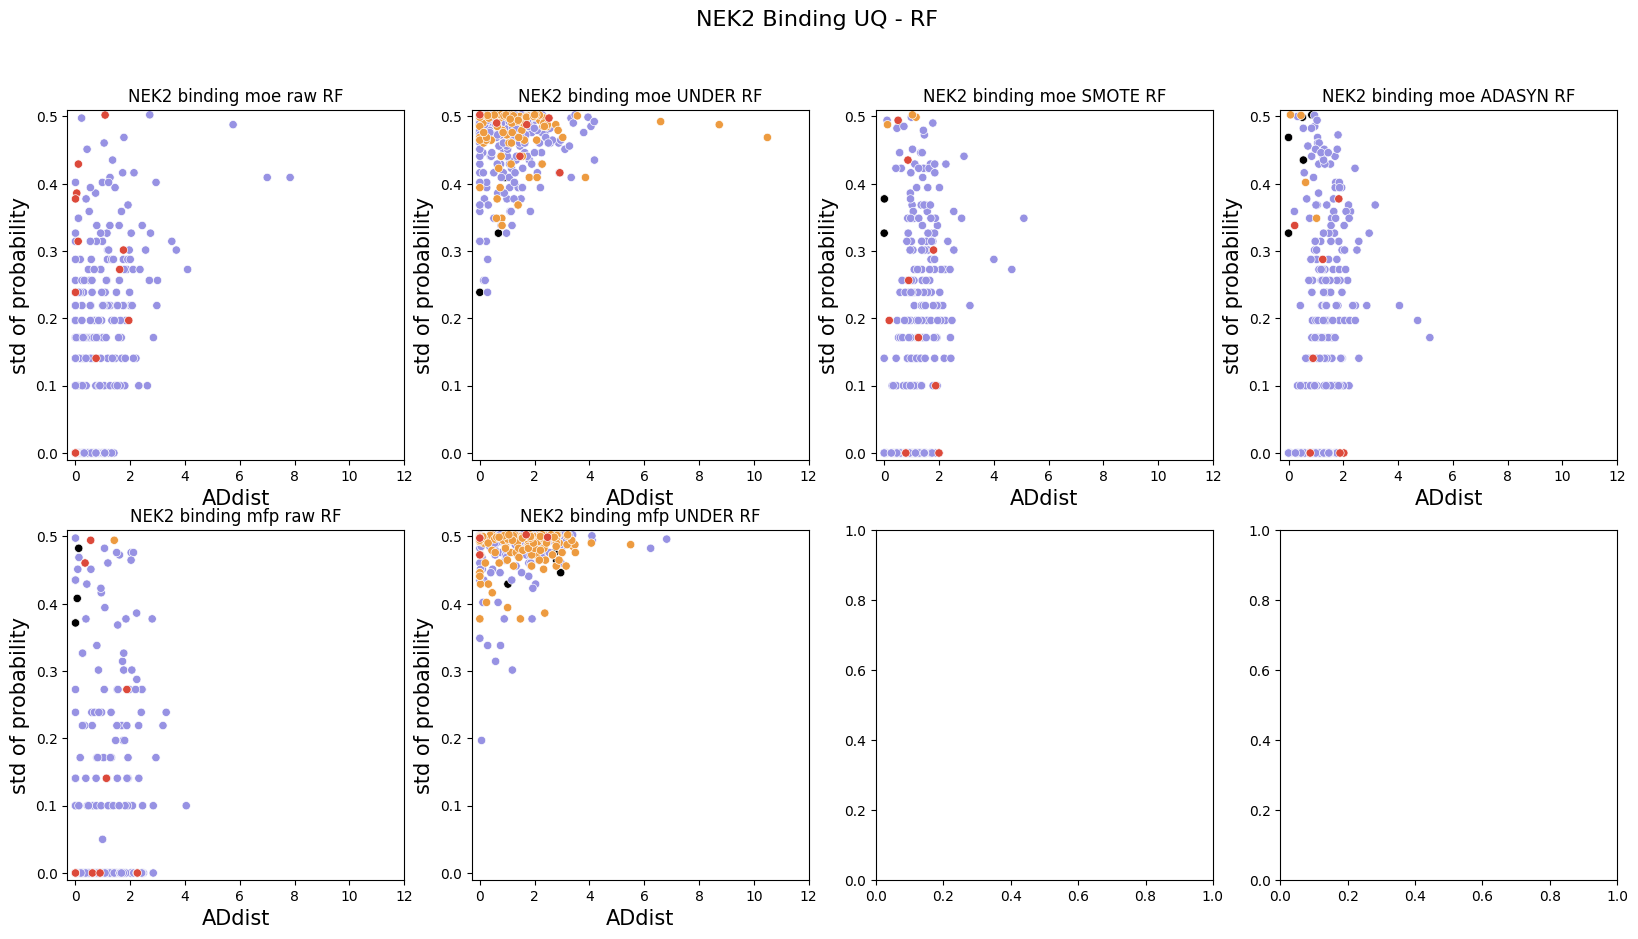

In [8]:
RF_types = ['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']
figure_path4 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_RF_std_prob/scatter/subplots/'
for this_rf in RF_types: 
    for nek in nek_list:
        if nek in ['2', '9']: 
            bind_inhib = ['binding', 'inhibition'] 
        else: 
            bind_inhib = ['binding'] 
        for bi in bind_inhib: 
            if bi == 'binding': 
                this_bi = 'bind'
            else: 
                this_bi = 'inhib' 
            fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
            fig.suptitle(f'NEK{nek} Binding UQ - {this_rf}', fontsize=16)
            
            for i, feat in enumerate(feat_types): 
                for j, samp in enumerate(samplings):
                    ax = axes[i,j]
                    
                    df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{this_bi}/'
                    full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv')
                    train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                    test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                    test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                    train_dist = calc_AD_kmean_dist(train_df, train_df, k)
    
                    pred = pd.read_csv(f'{result_path}NEK{nek}_{bi}_{feat}_{samp}_{this_rf}_test.csv')
                    stdprobs = pd.read_csv(f'{prob_path}NEK{nek}_{bi}_std_prob_{samp}_{this_rf}.csv')
                    std0 = stdprobs[f'std0_{feat}'].to_numpy()
                    std1 = stdprobs[f'std1_{feat}'].to_numpy()
                    preds = pred['prediction']
                    print(f"NEK{nek} {feat} {samp} {pred['cm'][0]}")
                    # display(pred)
                    true_labels = pred['y'].to_numpy()
        
                    df = pd.DataFrame({'prediction': preds, 'prediction_type': pred['prediction_type'], 'std0': std0, 'std1': std1, 'ADdist': test_dist})
                    df['feat_type'] = feat
        
                    if samp == 'scaled':
                        samp = 'raw'
                
                    RF_scatter_stdprob_AD_sbuplots(df, true_labels, f'NEK{nek} {bi} {feat} {samp} {this_rf}', ax)
    
                    if samp == 'raw':
                        samp = 'scaled'
                    
            print(f'NEK{nek} bind {this_rf}') 
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            # fig.savefig(f'{figure_path4}NEK{nek}_{bi}_{this_rf}_UQ_AD.png' ,bbox_inches='tight')
            plt.show(); 


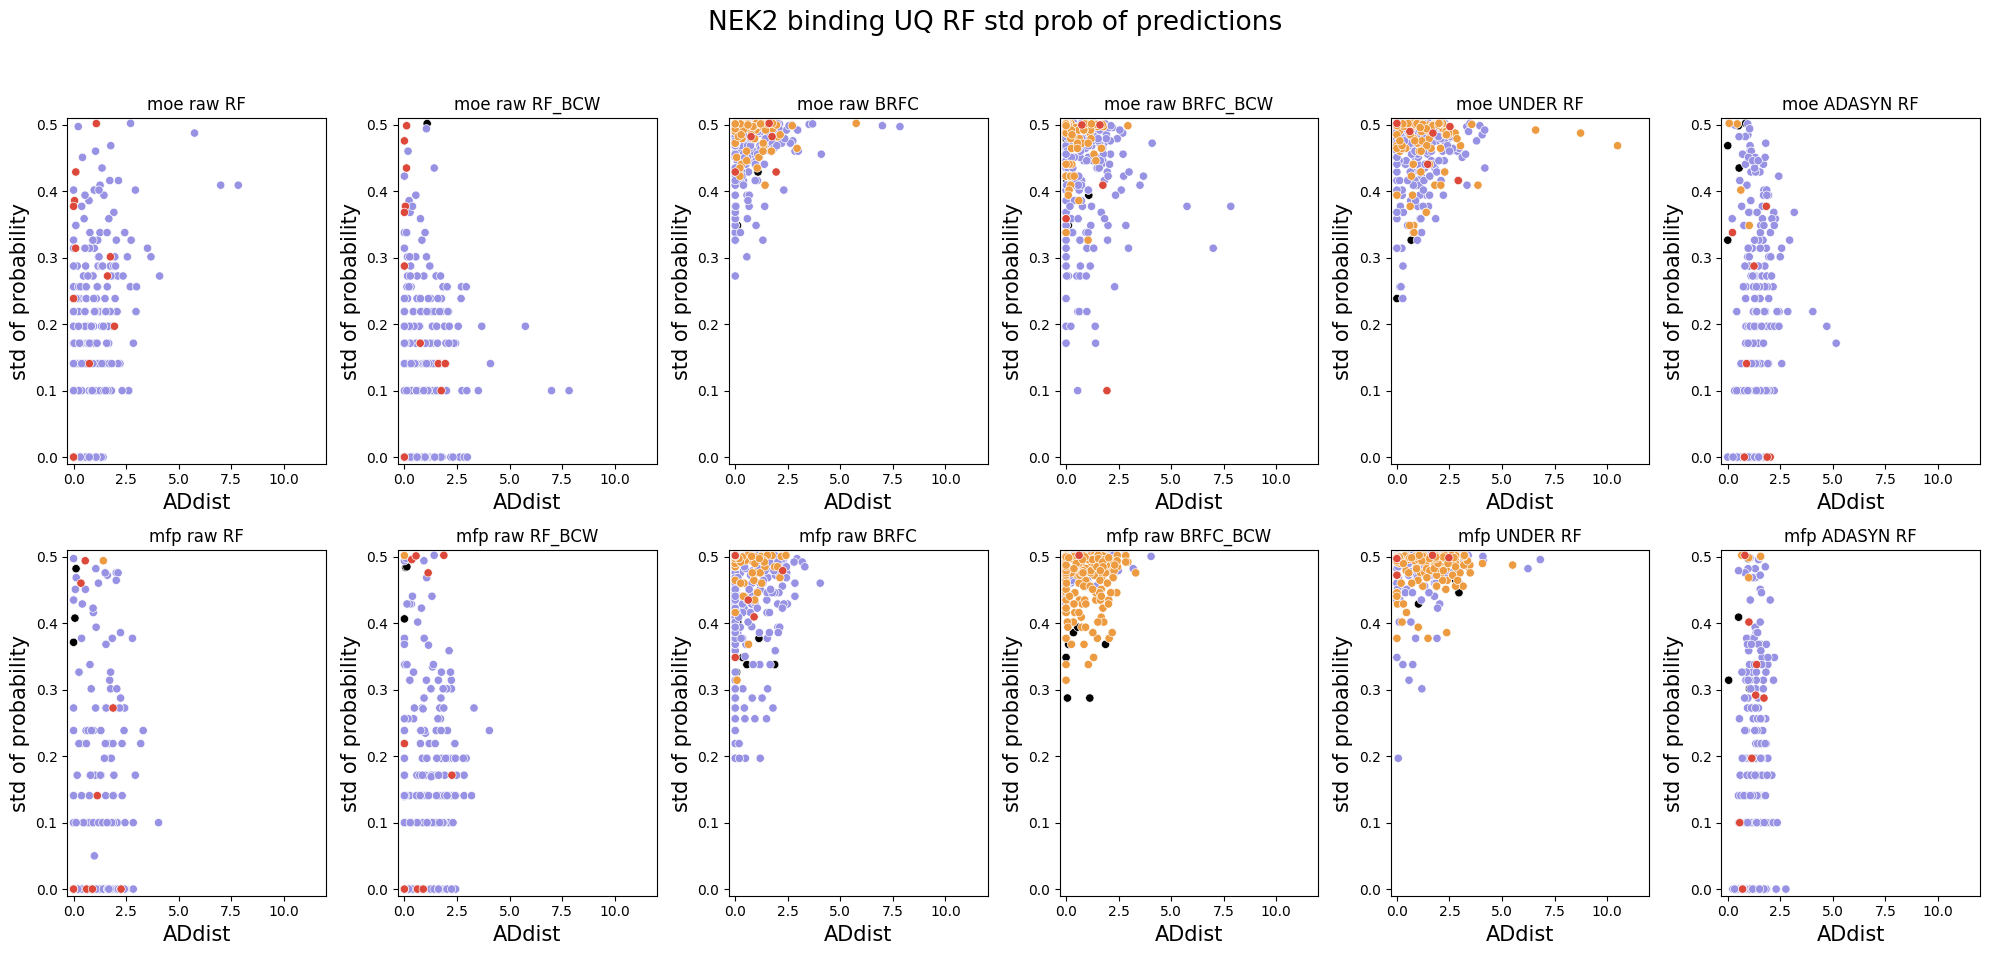

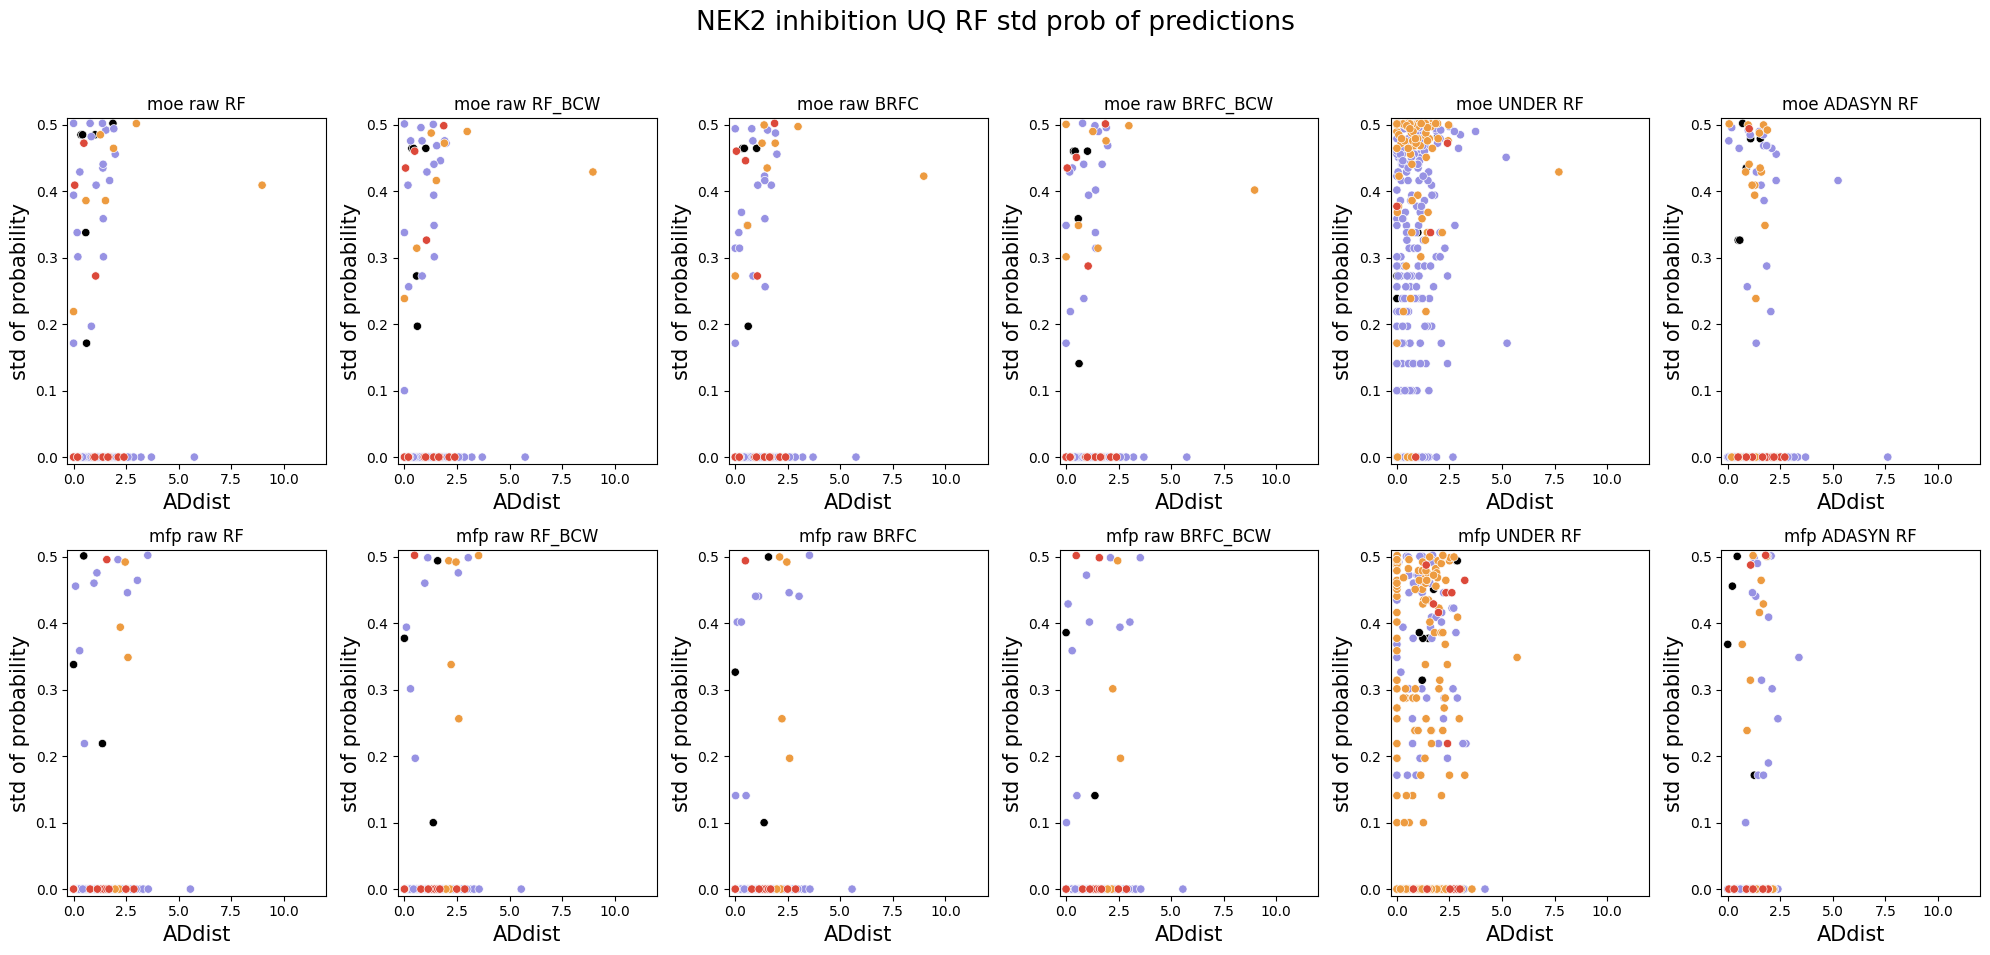

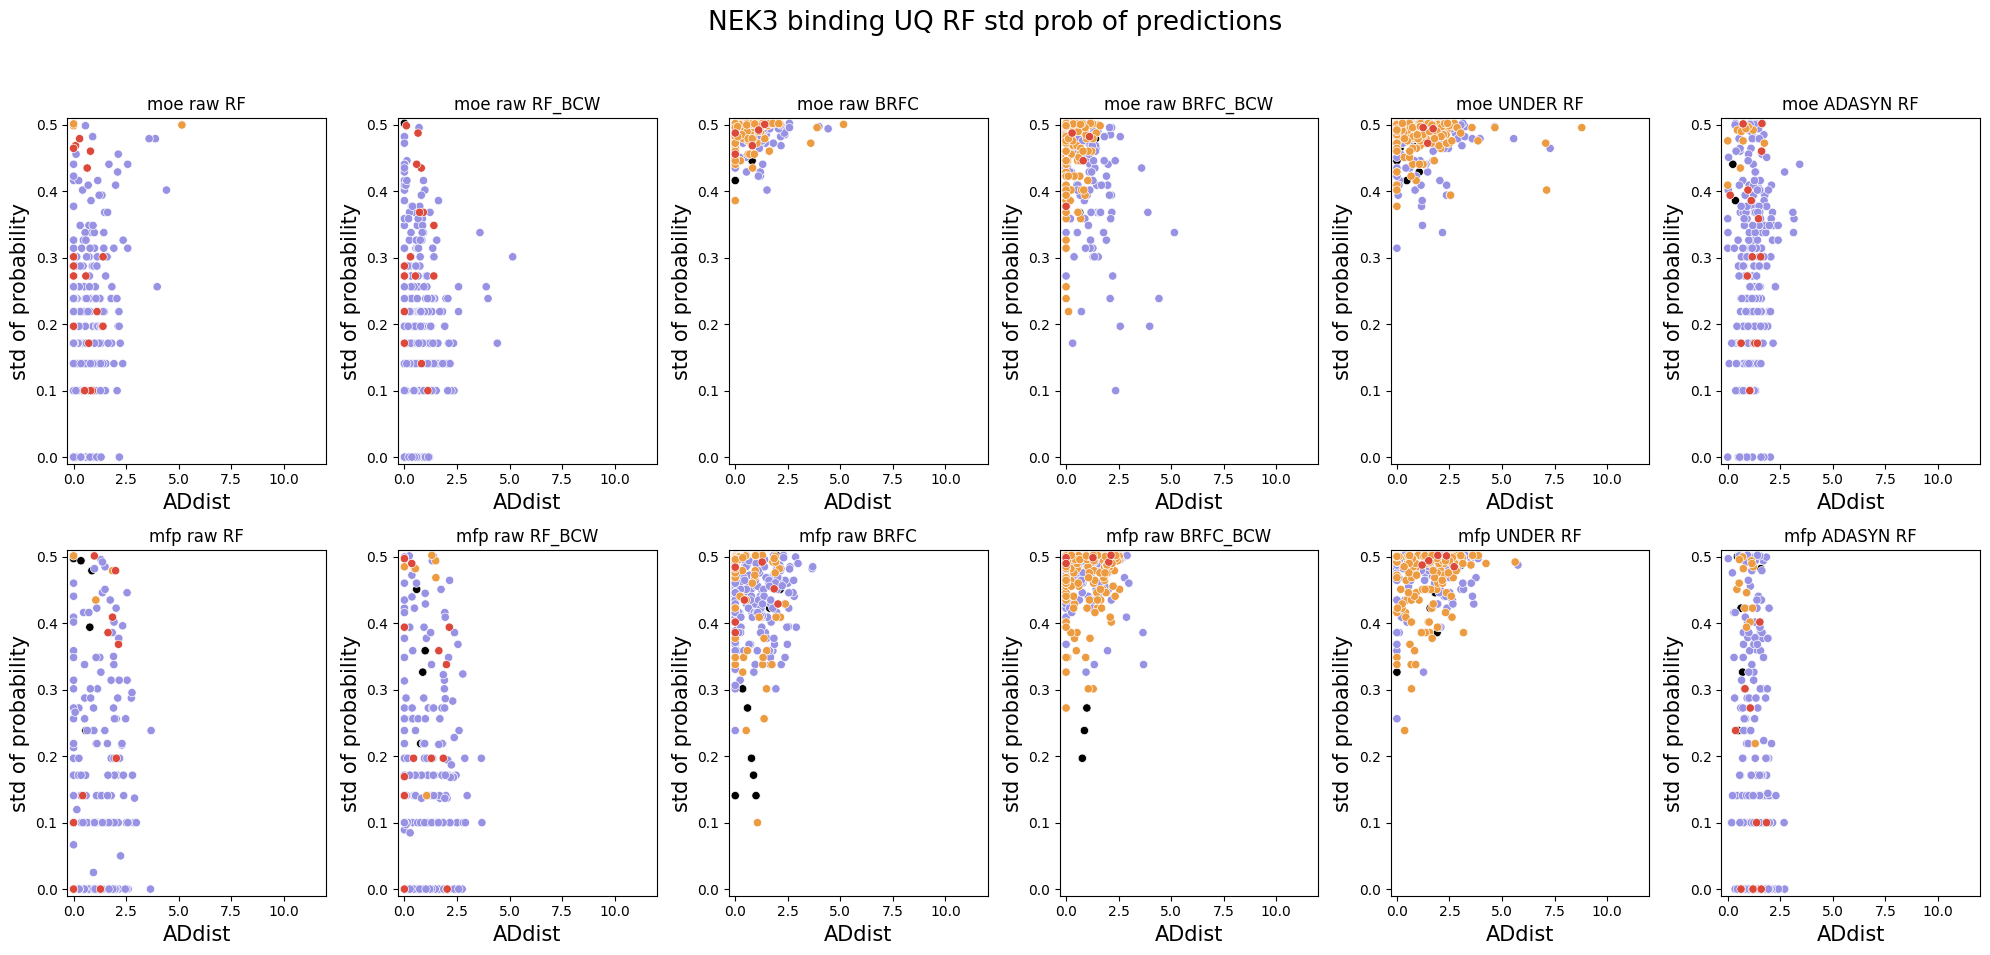

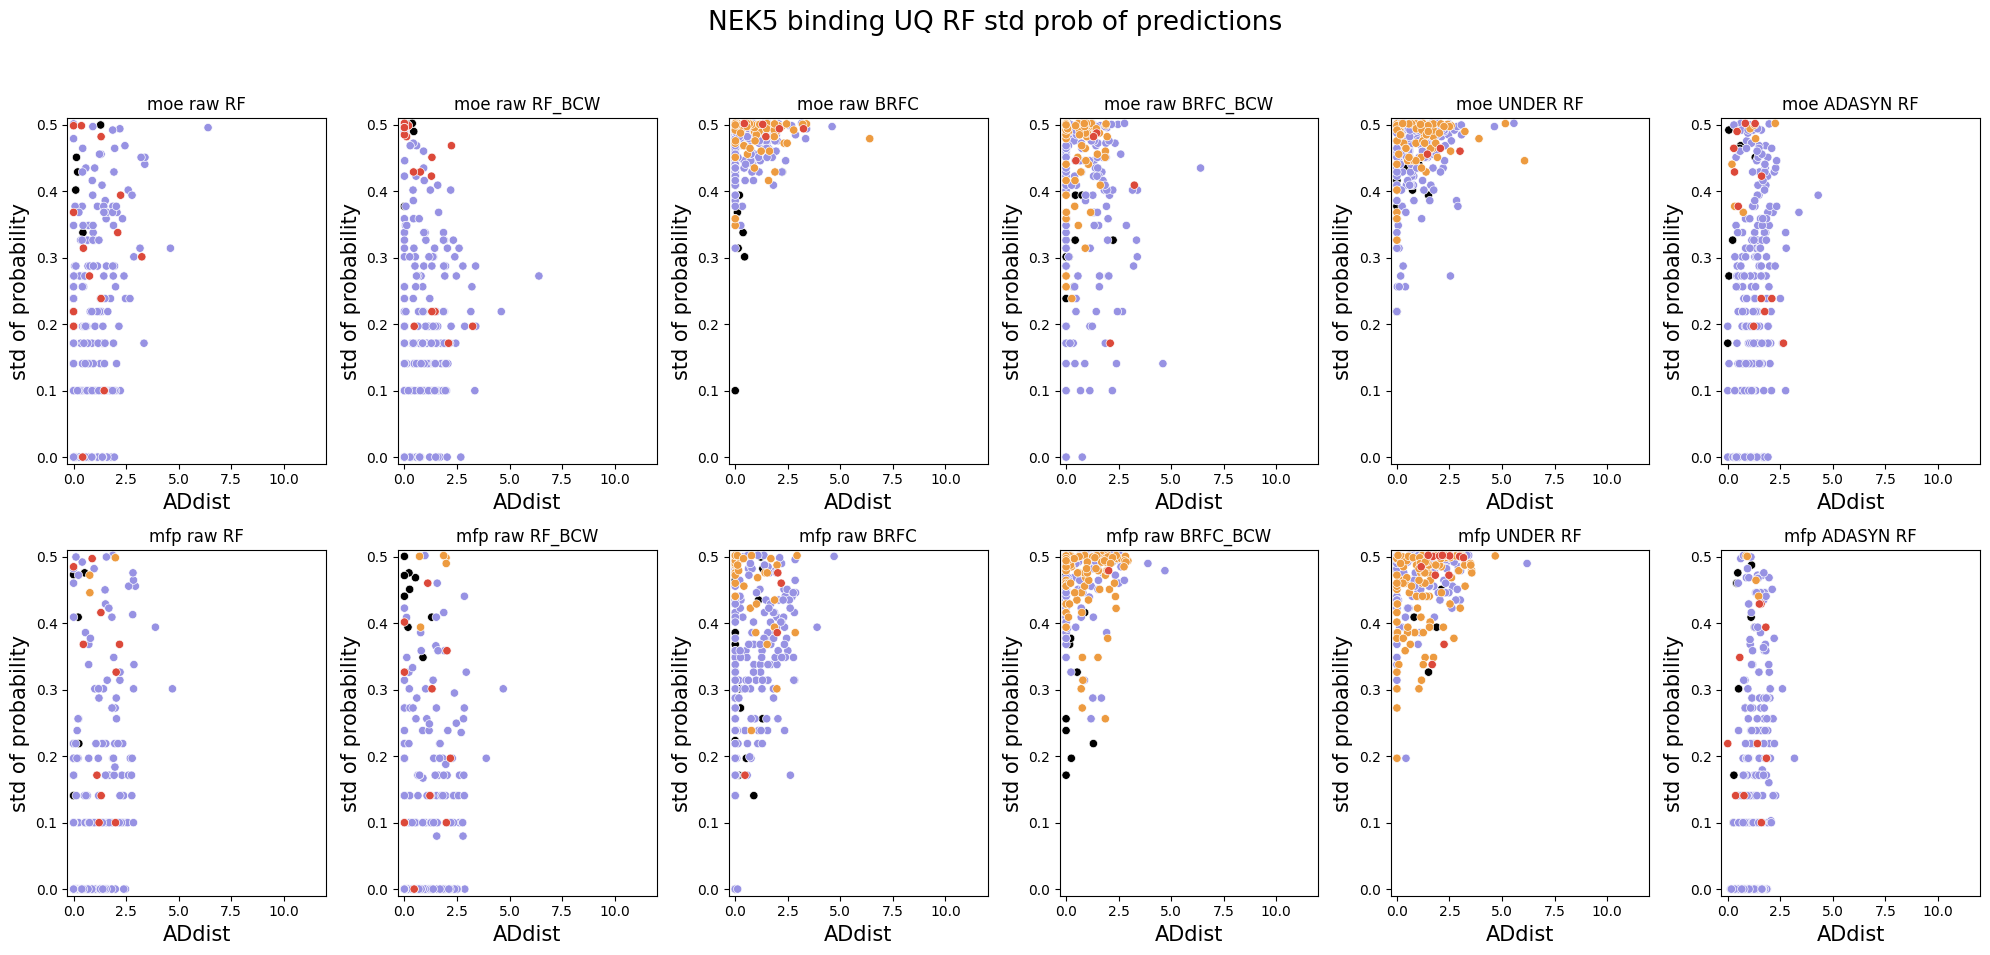

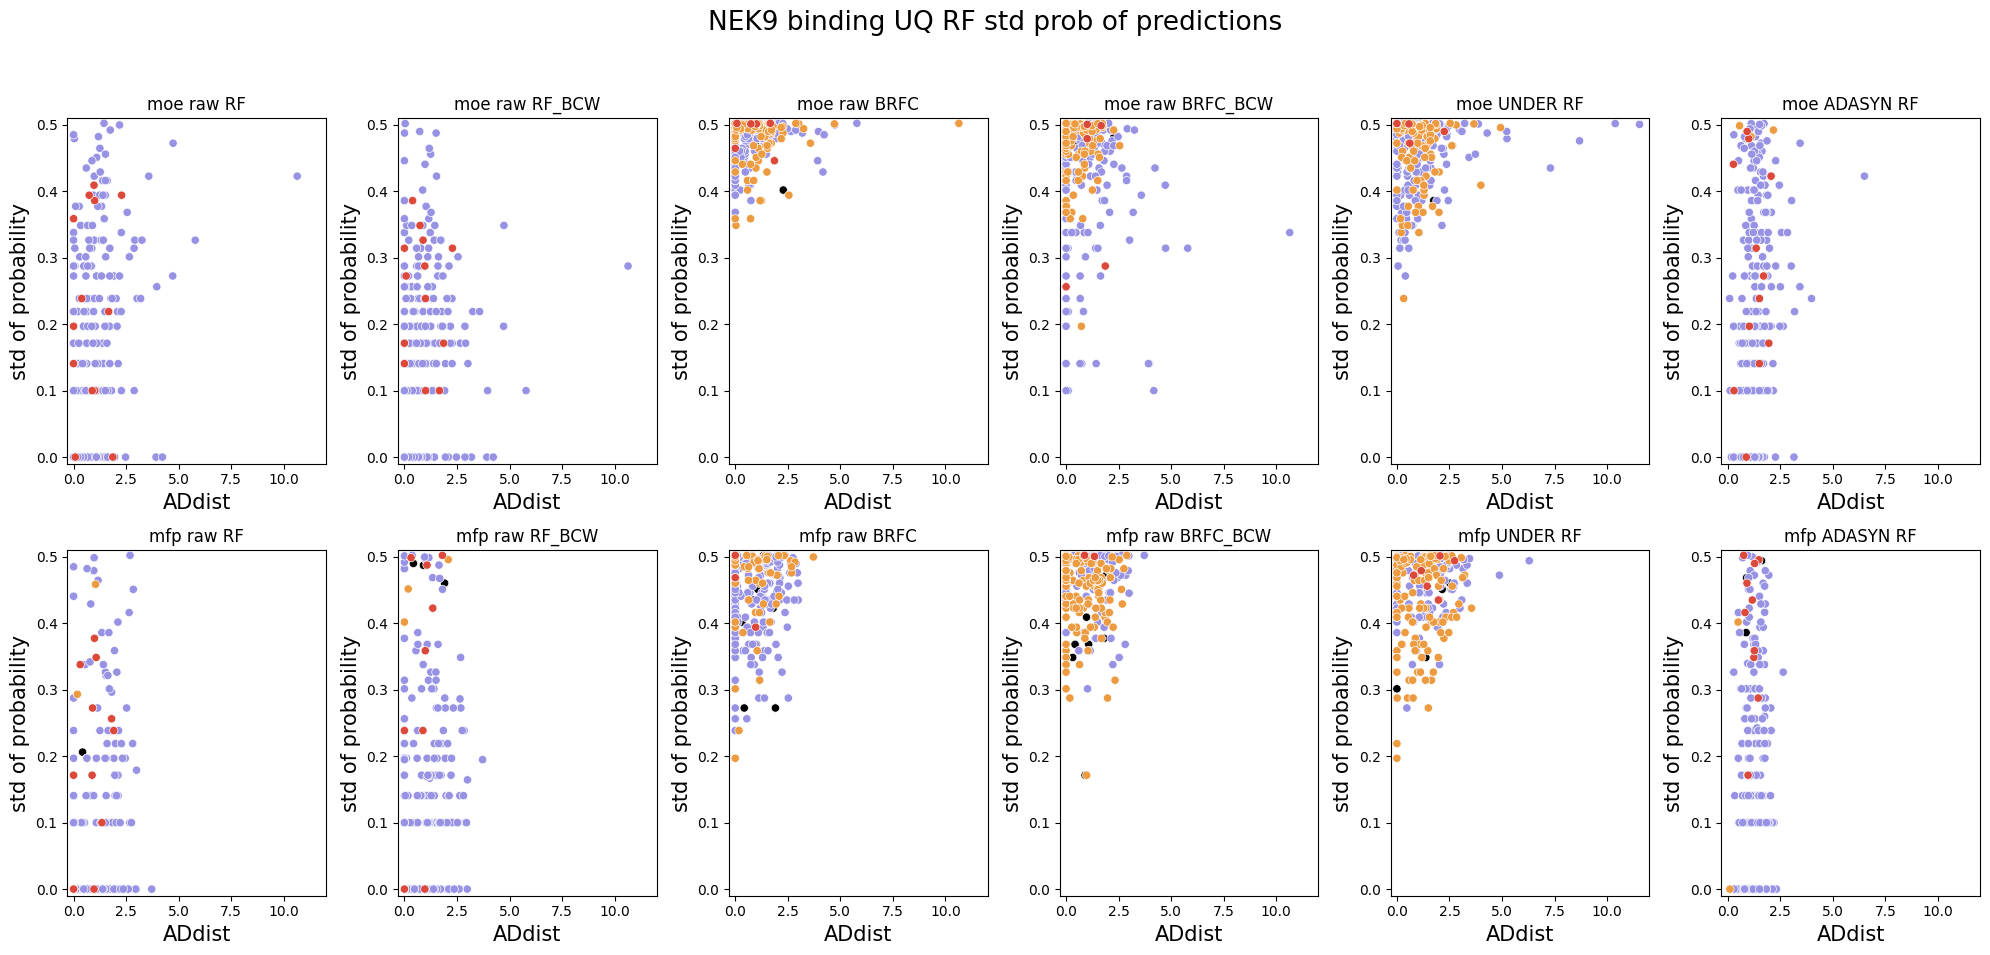

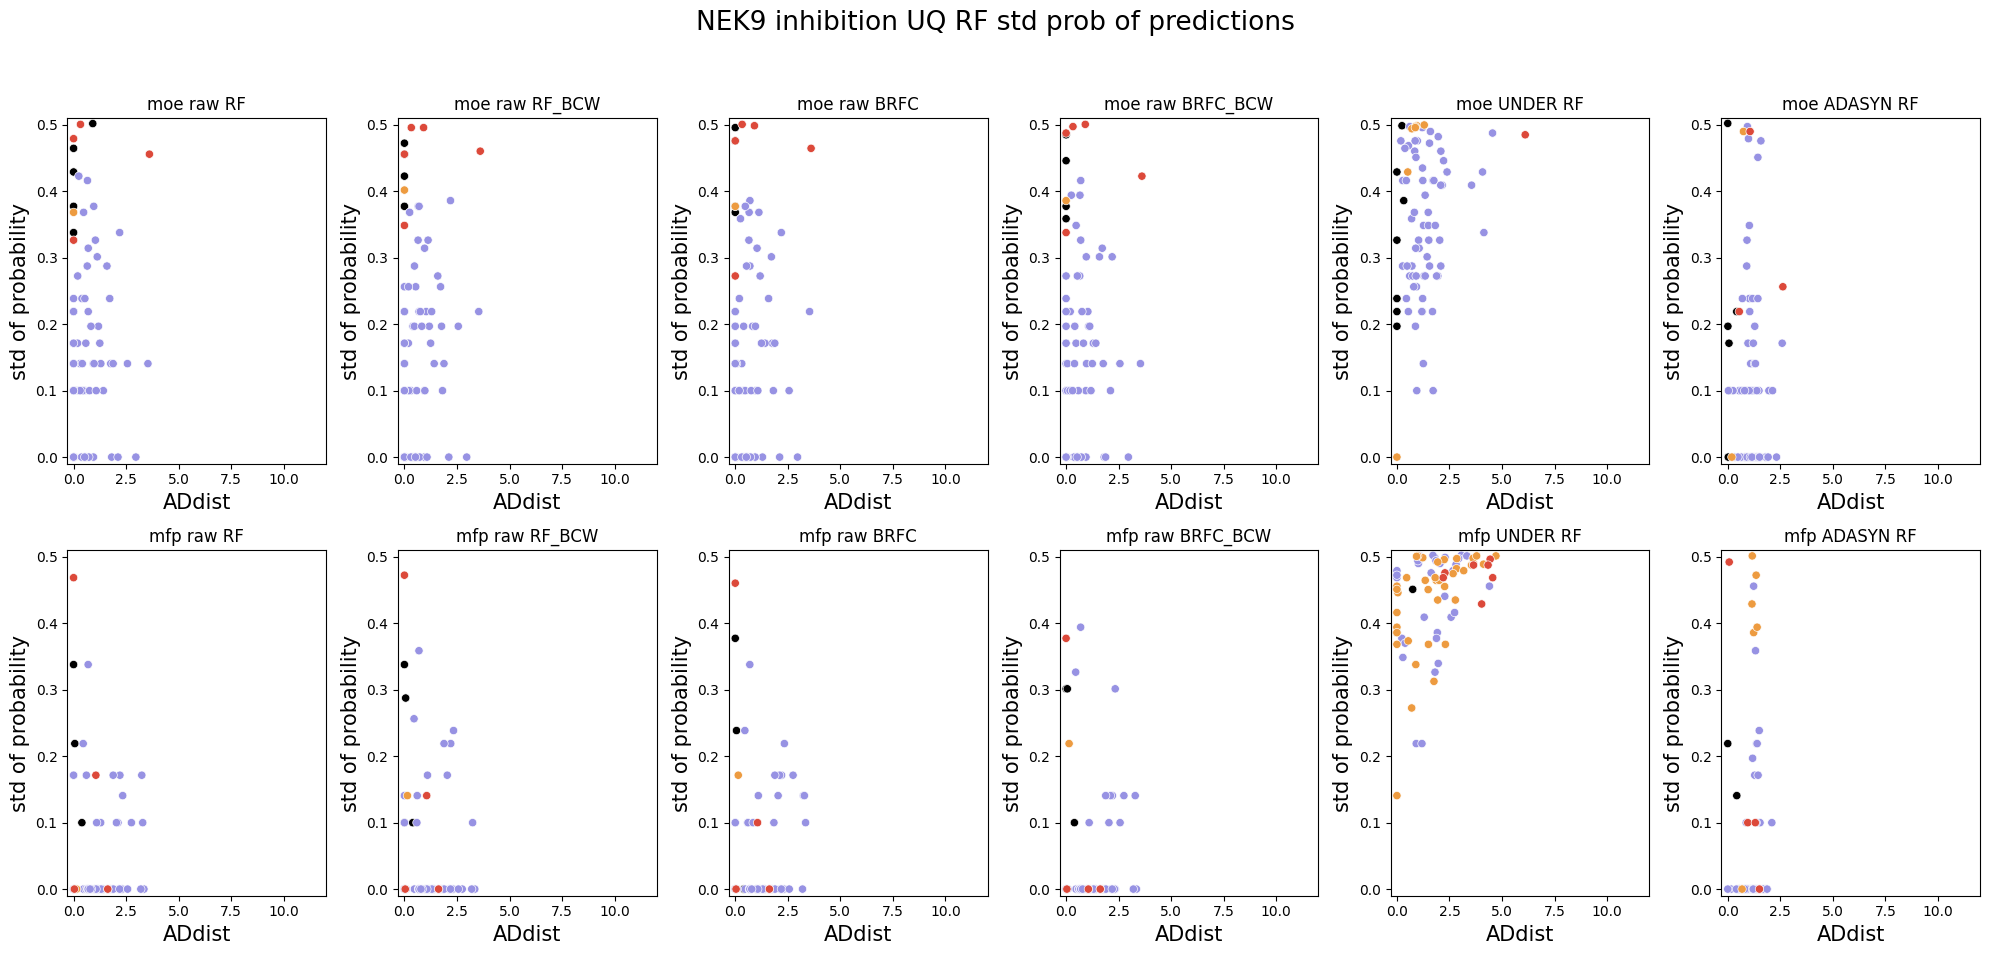

In [9]:
figure_path4 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_RF_std_prob/scatter/subplots/balancing_techniques/'
# row 1 (moe): raw RF, raw RFBCW, raw BRFC, raw BRFC_BCW, UNDER RF, ADASYN RF 
                    # 0   1           2         3           4          5
for nek in nek_list:
    if nek in ['2', '9']:
        bind_inhib = ['binding', 'inhibition']
    else:
        bind_inhib = ['binding']
    for bi in bind_inhib:
        if bi == 'binding':
            this_bi = 'bind'
        else:
            this_bi = 'inhib'
        fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 10))
        fig.suptitle(f'NEK{nek} {bi} UQ RF std prob of predictions', fontsize=19)
        count=0
        for i, feat in enumerate(feat_types):
            if feat == 'moe':
                sampling_combos = [
                    ('scaled', ['RF','RF_BCW', 'BRFC', 'BRFC_BCW']),('UNDER',['RF']),('ADASYN',['RF'])]
            else:
                count = 0
                sampling_combos = [('scaled',['RF','RF_BCW','BRFC','BRFC_BCW']),('UNDER',['RF']),('ADASYN',['RF'])]
            for samp, RF_types in sampling_combos:
                for rf in RF_types:
                    if count >= len(axes.flatten()):
                        break
                    ax = axes[i, count]
                    count += 1
                    df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{this_bi}/'
                    full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv')
                    train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                    test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
 
                    test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                    train_dist = calc_AD_kmean_dist(train_df, train_df, k)

                    pred = pd.read_csv(f'{result_path}NEK{nek}_{bi}_{feat}_{samp}_{rf}_test.csv')
                    stdprobs = pd.read_csv(f'{prob_path}NEK{nek}_{bi}_std_prob_{samp}_{rf}.csv')
                    std0 = stdprobs[f'std0_{feat}'].to_numpy()
                    std1 = stdprobs[f'std1_{feat}'].to_numpy()
                    preds = pred['prediction']
                    true_labels = pred['y'].to_numpy()

                    df = pd.DataFrame({
                        'prediction': preds,'prediction_type': pred['prediction_type'],'std0': std0,'std1': std1,'ADdist': test_dist})
                    df['feat_type'] = feat

                    if samp == 'scaled':
                        samp_label = 'raw'
                    else:
                        samp_label = samp
                    RF_scatter_stdprob_AD_sbuplots(df,true_labels, f'{feat} {samp_label} {rf}',ax)
                    if samp_label == 'raw':
                        samp_label = 'scaled'

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        fig.savefig(f'{figure_path4}NEK{nek}_{bi}.png', bbox_inches='tight')

# Distribution plots  

In [107]:
def plot_std_dist(dfs, title=None, figure_path=None, filename=None):
    modified_dfs=[] 
    for df in dfs: 
        modified_dfs.append(gather_plot_data(df))
        modified_dfs
    full_df = pd.concat(modified_dfs)
        
    plt.figure(figsize=(10, 8))
    fig = plt.figure(figsize=(6, 6))

    # sns.histplot(data=full_df, x='std of probabilities', hue='strategy')
    sns.kdeplot(data=full_df, x='std of probabilities', hue='strategy')
    if title is not None: 
        plt.title(title,x=0.5, y=1,fontsize=16)
    
    plt.xlabel('Std of probability', fontsize=14)
    plt.ylabel('Density',fontsize=14)

    if figure_path is not None: 
        plt.savefig(f'{figure_path}{filename}.png')
    plt.show();


<Figure size 1000x800 with 0 Axes>

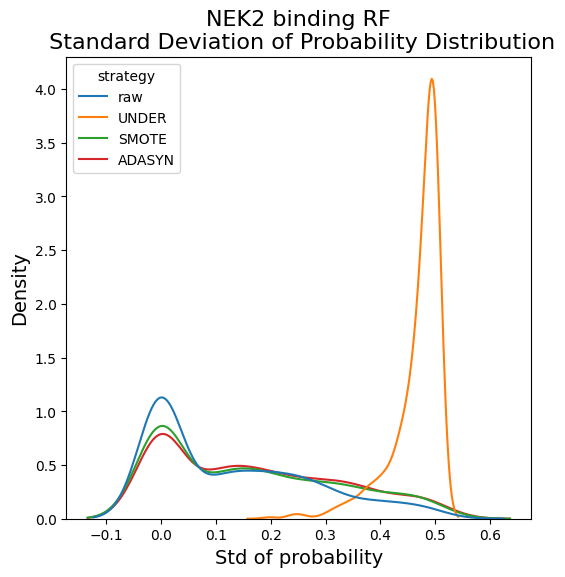

<Figure size 1000x800 with 0 Axes>

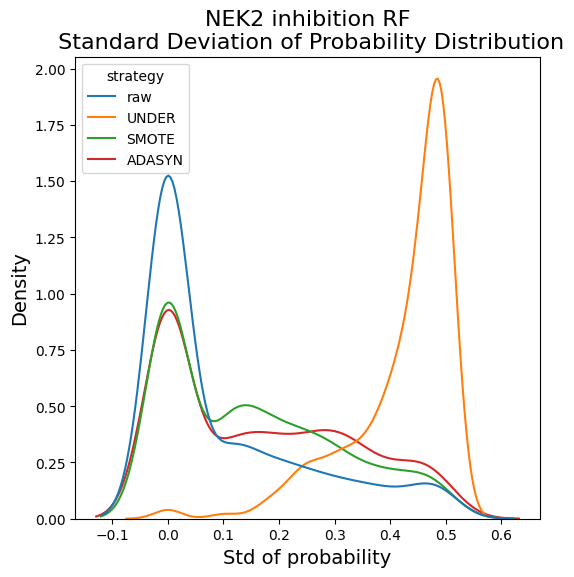

<Figure size 1000x800 with 0 Axes>

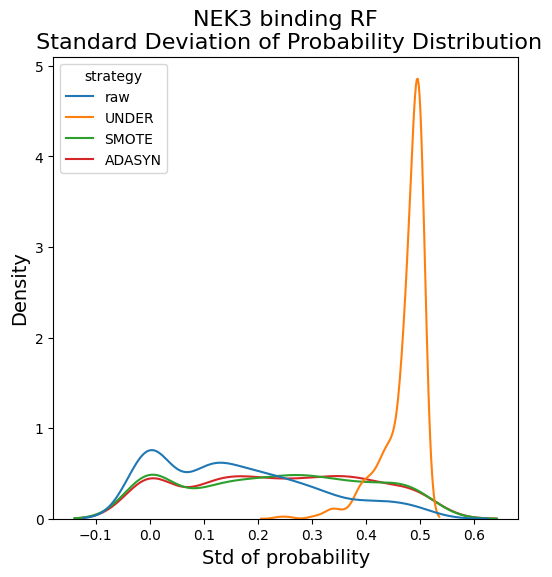

<Figure size 1000x800 with 0 Axes>

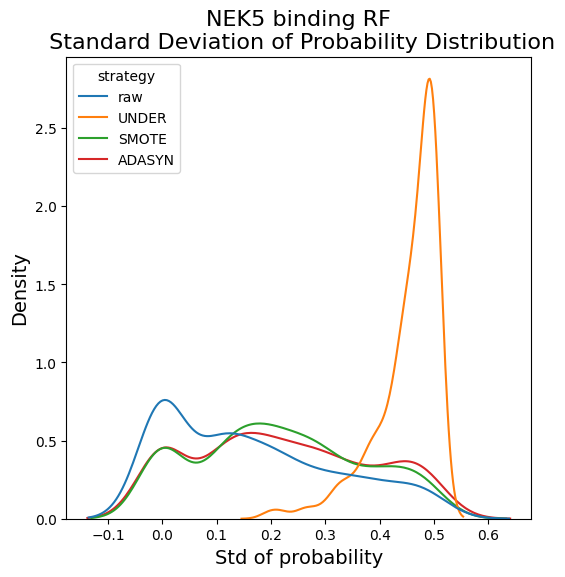

<Figure size 1000x800 with 0 Axes>

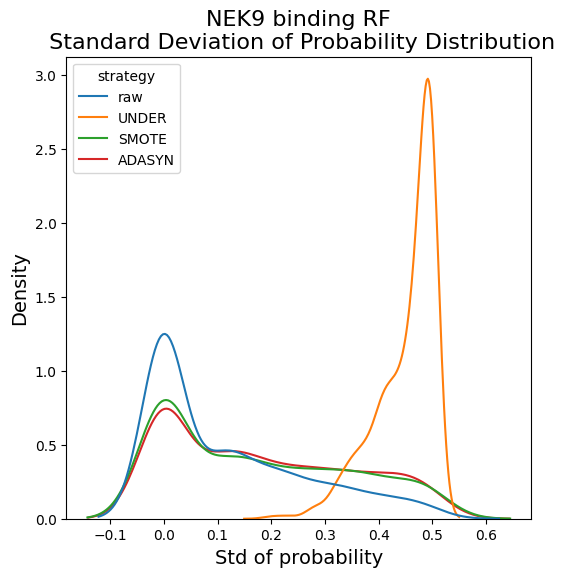

<Figure size 1000x800 with 0 Axes>

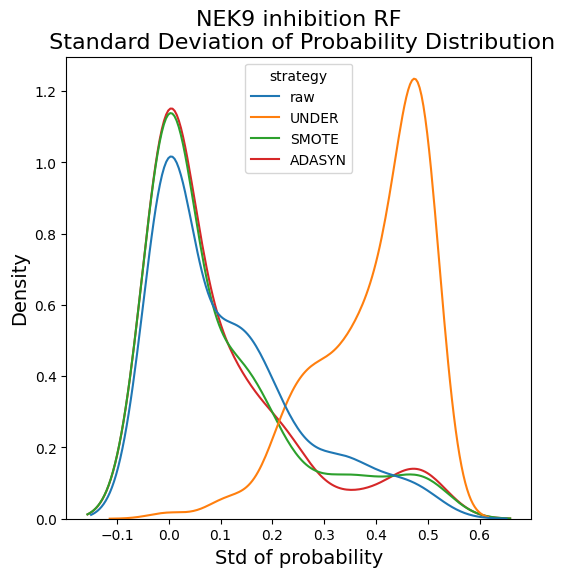

<Figure size 1000x800 with 0 Axes>

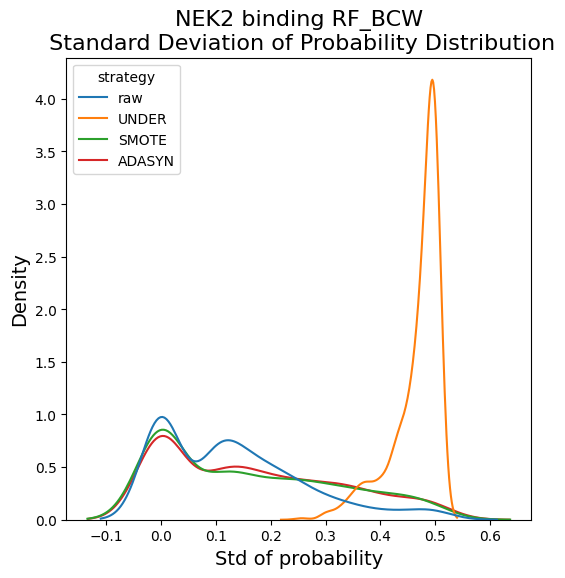

<Figure size 1000x800 with 0 Axes>

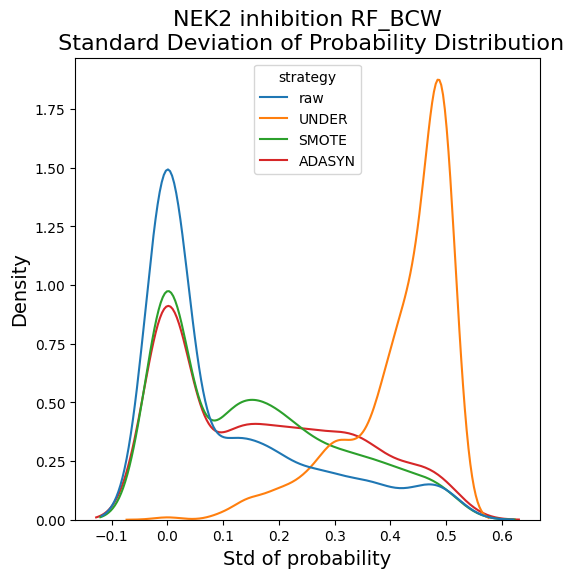

<Figure size 1000x800 with 0 Axes>

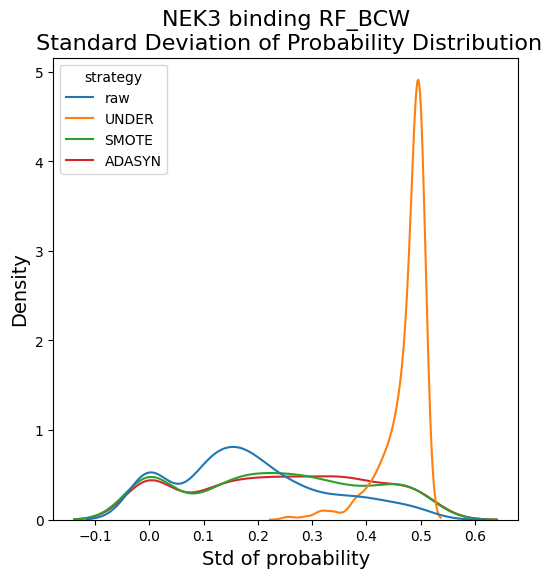

<Figure size 1000x800 with 0 Axes>

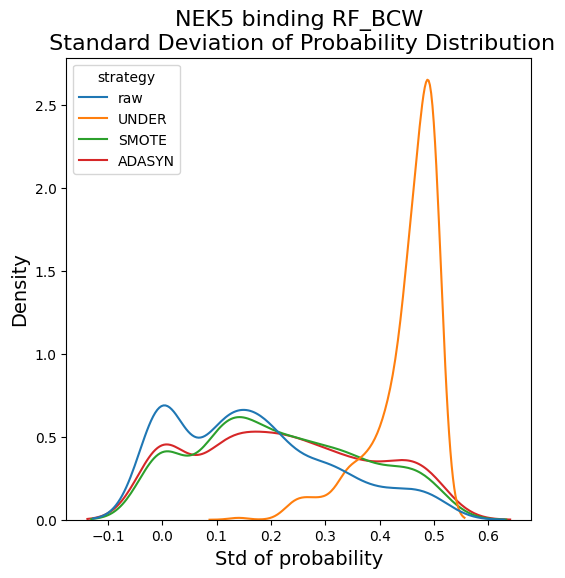

<Figure size 1000x800 with 0 Axes>

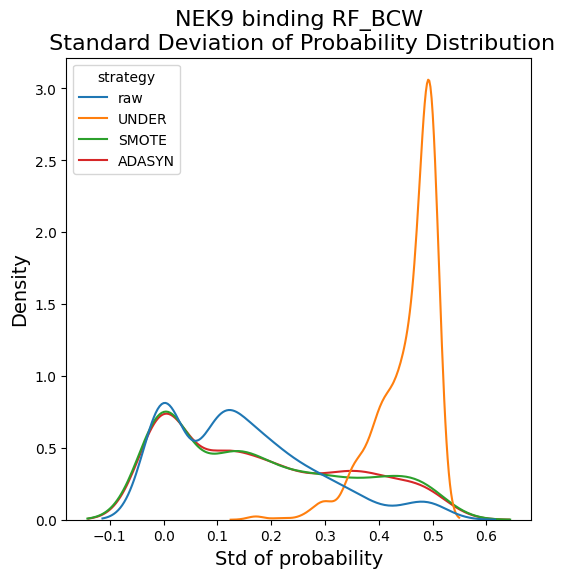

<Figure size 1000x800 with 0 Axes>

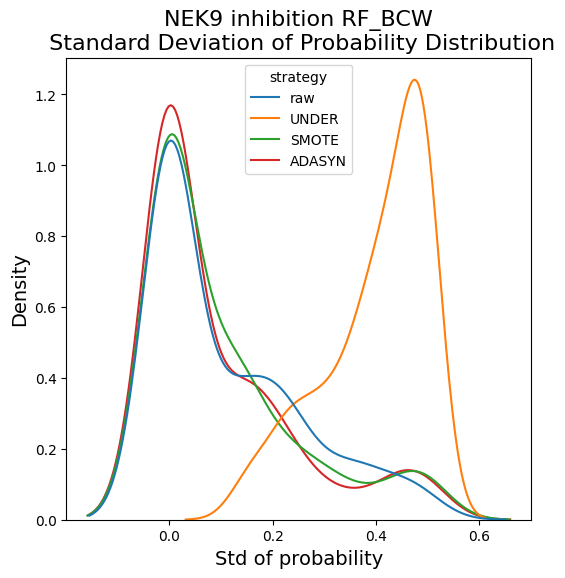

<Figure size 1000x800 with 0 Axes>

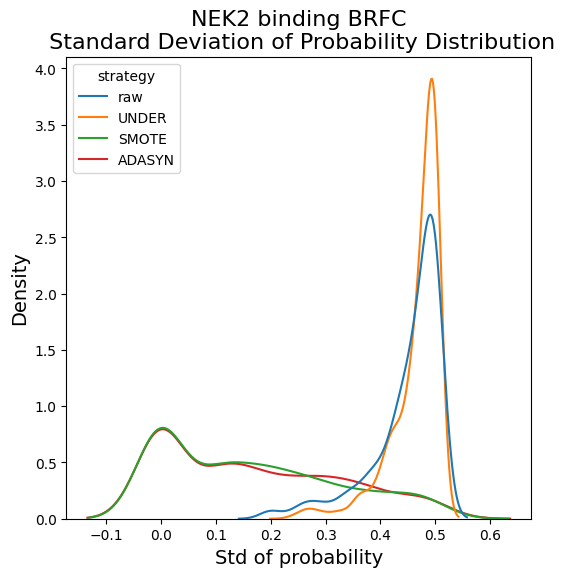

<Figure size 1000x800 with 0 Axes>

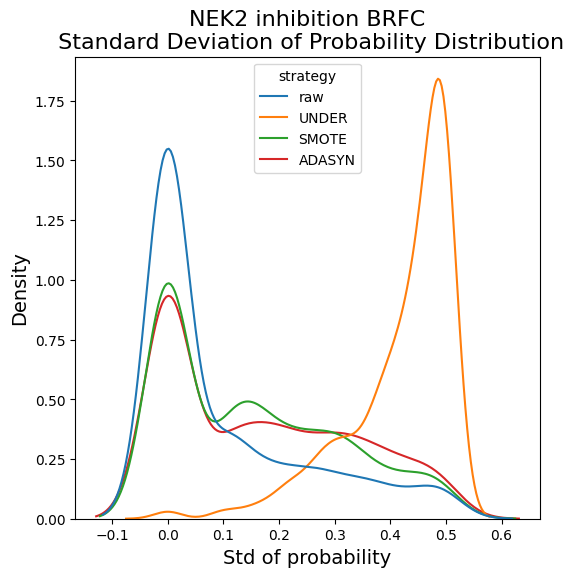

<Figure size 1000x800 with 0 Axes>

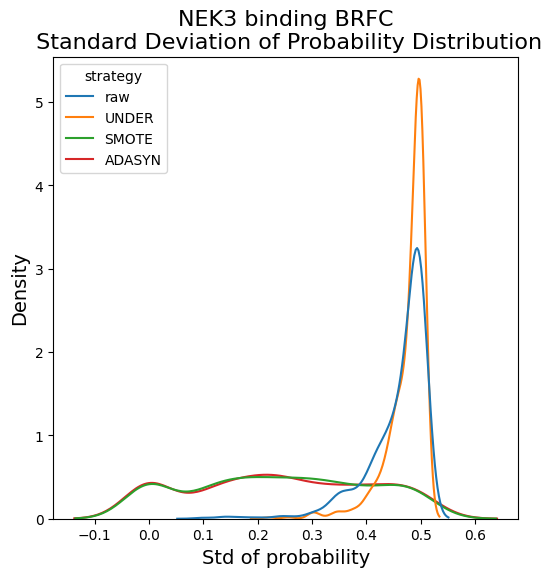

<Figure size 1000x800 with 0 Axes>

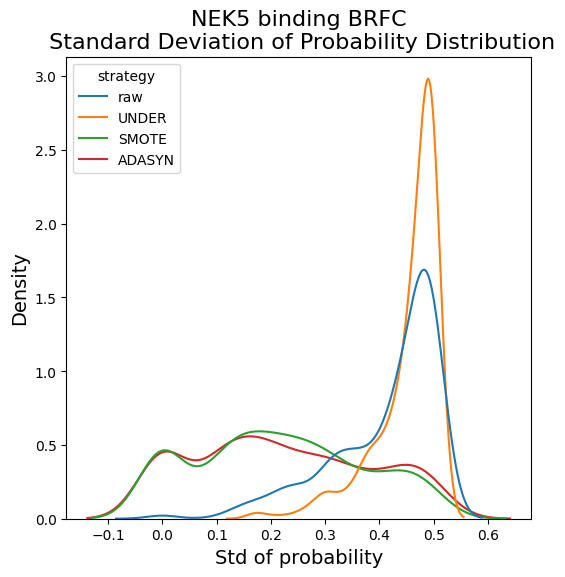

<Figure size 1000x800 with 0 Axes>

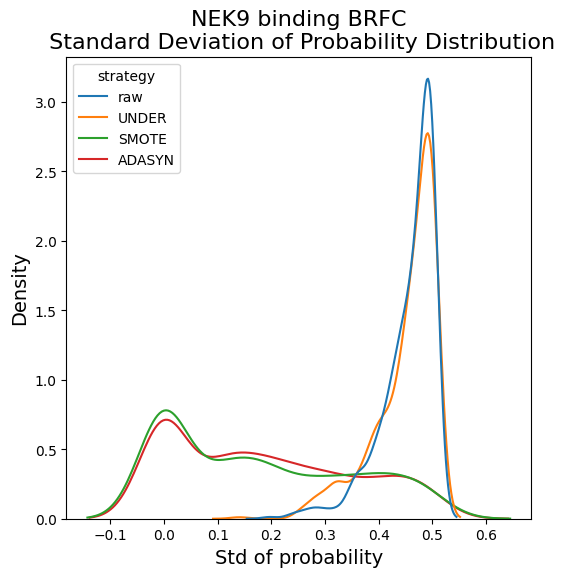

<Figure size 1000x800 with 0 Axes>

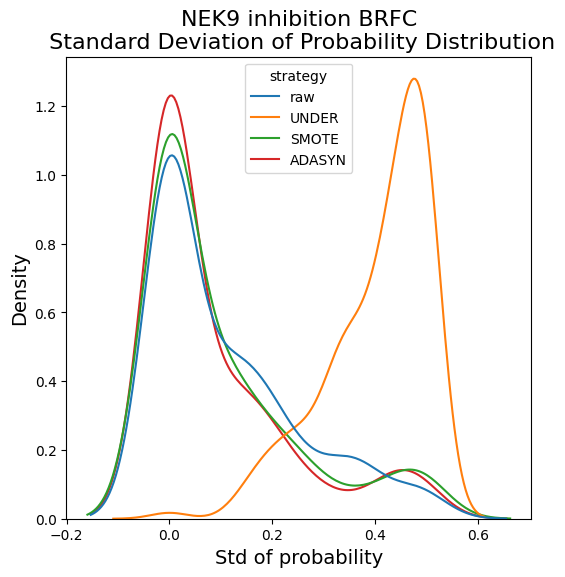

<Figure size 1000x800 with 0 Axes>

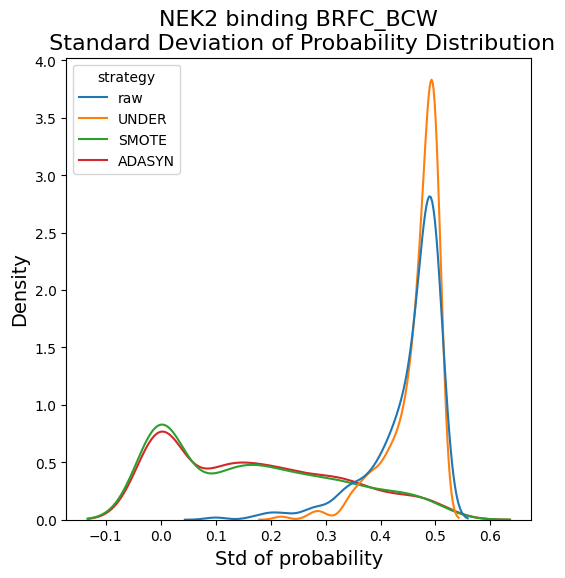

<Figure size 1000x800 with 0 Axes>

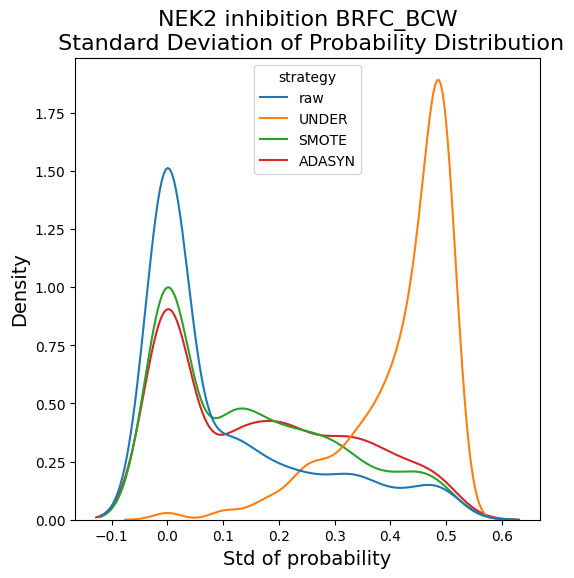

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [85]:
for rf in RF_types: 
    for nek in neks:
        dfs = [] 
        for feat in feat_types: 
            for samp in samplings: 
                df_root, bind_inhib = course_correct(nek)
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/{df_root}'
                nek_num = nek[3]
                full_df = pd.read_csv(f'{df_path}NEK{nek_num}_{bind_inhib}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                pred = pd.read_csv(f'{result_path}NEK{nek_num}_{bind_inhib}_{feat}_{samp}_{rf}_test.csv')
                stdprobs = pd.read_csv(f'{prob_path}NEK{nek_num}_{bind_inhib}_std_prob_{samp}_{rf}.csv')
                std0 = stdprobs[f'std0_{feat}'].to_numpy()
                std1= stdprobs[f'std1_{feat}'].to_numpy()
                preds = pred['prediction']
                true_labels =pred['y'].to_numpy()
                
                cm = pred['cm'][0]
                df = pd.DataFrame({'prediction': preds, 'prediction_type':pred['prediction_type'], 'std0': std0, 'std1': std1, 'ADdist': test_dist, 'true_labels':true_labels,'cm':cm})
                if (samp=='scaled'): 
                    samp='raw'
                df['NEK'] = nek
                df['feat_type'] = feat
                df['strategy'] = samp 
                df['RF_type'] = rf
                df['recall'] = pred['recall'].iloc[0]
                dfs.append(df) 
                if (samp=='raw'): 
                    samp='scaled'
        title = f'NEK{nek_num} {bind_inhib} {rf}\n Standard Deviation of Probability Distribution' 
        plot_std_dist(dfs,title)


# moe and mfp subplots 

In [108]:
dataset_colors = {'raw': 'midnightblue', 'UNDER': 'orangered','SMOTE': 'darkgreen','ADASYN':'darkred' }
dataset_colors = {'raw': 'midnightblue', 'UNDER': 'orangered','SMOTE': 'darkgreen','ADASYN':'darkred' }
strategy_order = list(dataset_colors.keys())
def plot_std_dist_moemfp(dfs, title=None, figure_path=None, filename=None):
    modified_dfs=[] 
    strategy_cm_map = {}
    recall_map = {}
    
    for df in dfs:
        
        this_df = gather_plot_data(df)
        this_this_df = this_df[this_df['feat_type'] == moe_or_mfp]
        modified_dfs.append(this_this_df)
        
        strategy = this_this_df['strategy'].iloc[0]
        cm_value = this_this_df['cm'].iloc[0]
        cm_value_str = str(cm_value)
        recall_map[strategy] = f"{this_this_df['recall'].iloc[0]:.2f}"
        strategy_cm_map[strategy] = cm_value_str
    full_df = pd.concat(modified_dfs)
    
    # sns.kdeplot(data=full_df[full_df['feat_type'] == moe_or_mfp], x='std of probabilities', hue='strategy', 
    #             ax=ax, palette=dataset_colors, hue_order=strategy_order)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    sns.kdeplot(data=full_df[full_df['feat_type'] == 'moe'], x='std of probabilities', hue='strategy',ax=axs[0],
                palette=dataset_colors,hue_order=strategy_order)
    axs[0].set_title('moe', fontsize=14)
    axs[0].set_xlabel('Std of Probability', fontsize=14)
    axs[0].set_ylabel('Density', fontsize=12)
    
    sns.kdeplot(data=full_df[full_df['feat_type'] == 'mfp'], x='std of probabilities',hue='strategy',ax=axs[1],
                palette=dataset_colors, hue_order=strategy_order)
    axs[1].set_title('mfp', fontsize=14)
    axs[1].set_xlabel('Std of Probability', fontsize=14)
    labels = [f'{samp}, cm: {strategy_cm_map[samp]}, recall: {recall_map[samp]}' for samp in strategy_order]

    handles = [Line2D([0],[0], color=dataset_colors[samp], lw=2) for samp in strategy_order]
    ax.legend(handles, labels, title='Dataset, cm [TN, FP, FN, TP]', loc='upper left')
    if title is not None: 
        plt.suptitle(title,x=0.5, y=1,fontsize=16)
    
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{filename}.png')
    plt.show();

def plot_std_dist_moemfp2(dfs, title=None, figure_path=None, filename=None):
    all_mfp_dfs=[] 
    mfp_strategy_cm_map = {}
    mfp_recall_map = {}
    all_moe_dfs=[] 
    moe_strategy_cm_map = {}
    moe_recall_map = {}
    for df in dfs:
        this_df = gather_plot_data(df)

        if 'moe' in this_df['feat_type'].values:
            this_moe_df = this_df[this_df['feat_type'] == 'moe']
 
            all_moe_dfs.append(this_moe_df)
            strategy = this_moe_df['strategy'].iloc[0]
            moe_cm_value = this_moe_df['cm'].iloc[0]
            moe_cm_value_str = str(moe_cm_value)
            moe_recall_map[strategy] = f"{this_moe_df['recall'].iloc[0]:.2f}"
            moe_strategy_cm_map[strategy] = moe_cm_value_str
        if 'mfp' in this_df['feat_type'].values:
            this_mfp_df = this_df[this_df['feat_type'] == 'mfp']
            all_mfp_dfs.append(this_mfp_df)
            strategy = this_mfp_df['strategy'].iloc[0]
            mfp_cm_value = this_mfp_df['cm'].iloc[0]
            mfp_cm_value_str = str(mfp_cm_value)
            mfp_recall_map[strategy] = f"{this_mfp_df['recall'].iloc[0]:.2f}"
            mfp_strategy_cm_map[strategy] = mfp_cm_value_str
    full_moe_df = pd.concat(all_moe_dfs)
    full_mfp_df = pd.concat(all_mfp_dfs)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    if all_moe_dfs:
        full_moe_df = pd.concat(all_moe_dfs)
        sns.kdeplot(data=full_moe_df, x='std of probabilities', hue='strategy', ax=axs[0],
                    palette=dataset_colors, hue_order=strategy_order)
        axs[0].set_title('moe', fontsize=14)
        axs[0].set_xlabel('Std of Probability', fontsize=14)
        axs[0].set_ylabel('Density', fontsize=12)
        moe_labels = [f'{samp}, cm: {moe_strategy_cm_map[samp]}, recall: {moe_recall_map[samp]}' for samp in strategy_order if samp in moe_strategy_cm_map]
        handles = [Line2D([0], [0], color=dataset_colors[samp], lw=2) for samp in strategy_order]
        axs[0].legend(handles, moe_labels, title='MOE: Dataset, cm [TN, FP, FN, TP]', loc='upper left')
    else:
        fig.delaxes(axs[0])

    if all_mfp_dfs:
        full_mfp_df = pd.concat(all_mfp_dfs)
        sns.kdeplot(data=full_mfp_df, x='std of probabilities', hue='strategy', ax=axs[1],
                    palette=dataset_colors, hue_order=strategy_order)
        axs[1].set_title('mfp', fontsize=14)
        axs[1].set_xlabel('Std of Probability', fontsize=14)
        mfp_labels = [f'{samp}, cm: {mfp_strategy_cm_map[samp]}, recall: {mfp_recall_map[samp]}' for samp in strategy_order if samp in mfp_strategy_cm_map]
        handles = [Line2D([0], [0], color=dataset_colors[samp], lw=2) for samp in strategy_order]
        axs[1].legend(handles, mfp_labels, title='MFP: Dataset, cm [TN, FP, FN, TP]', loc='upper left')
    else:
        fig.delaxes(axs[1])  # Remove the subplot if no 'mfp' data

    if title is not None: 
        plt.suptitle(title, x=0.5, y=1, fontsize=16)
    
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{filename}.png')
    
    plt.show()


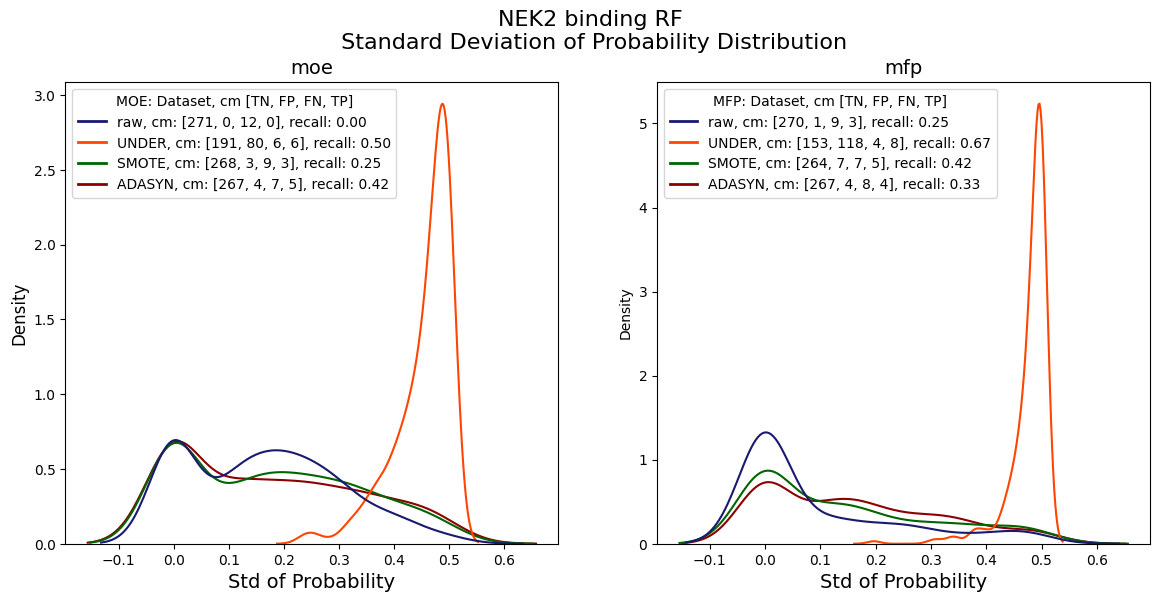

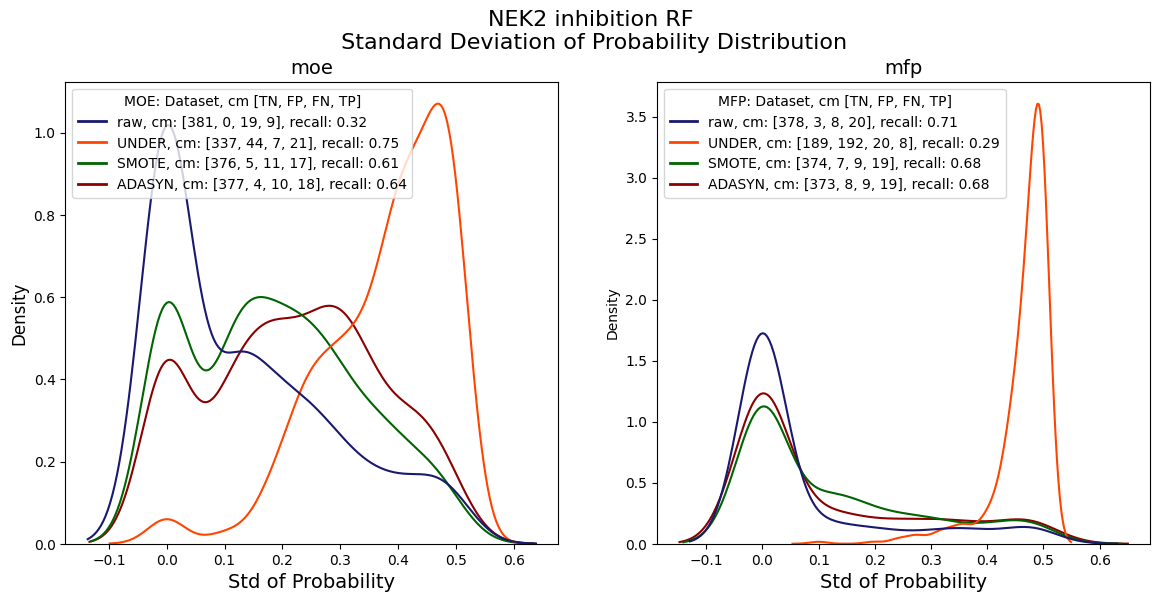

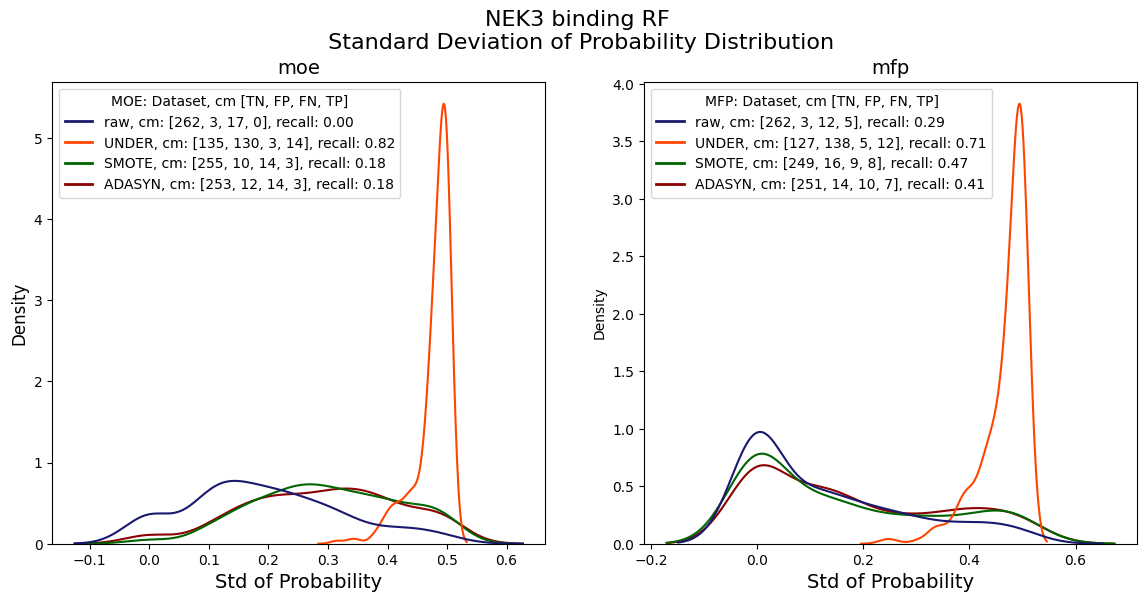

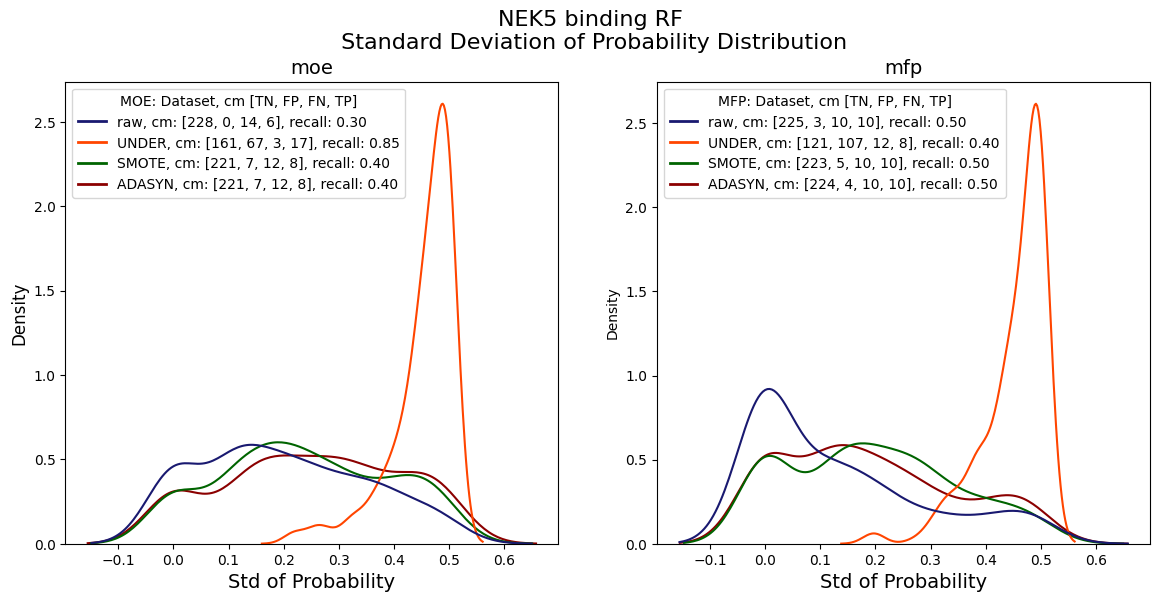

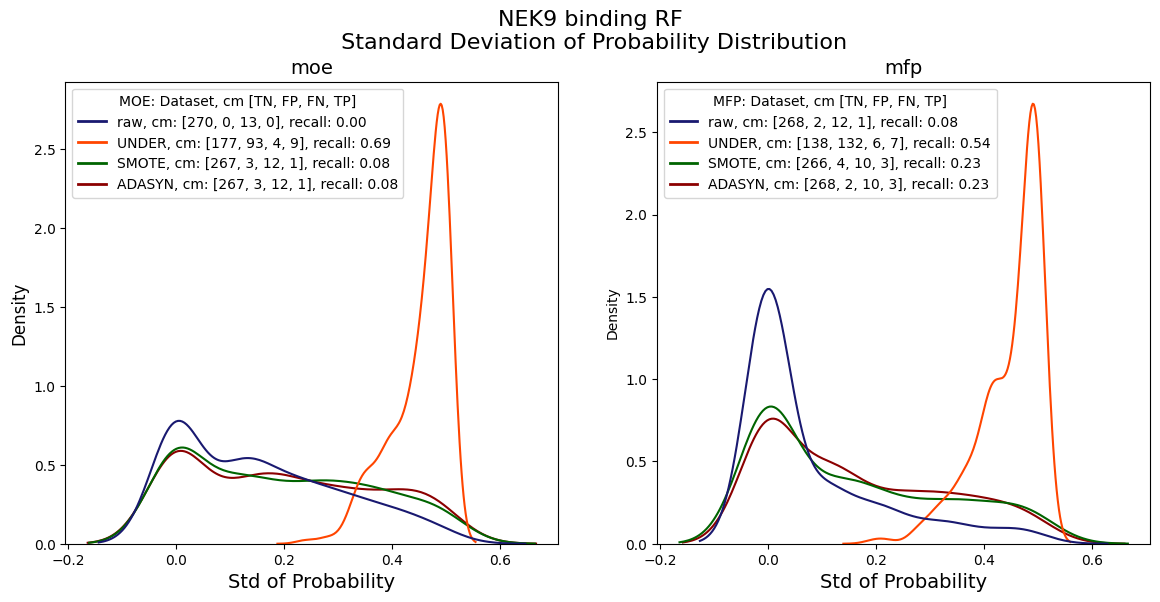

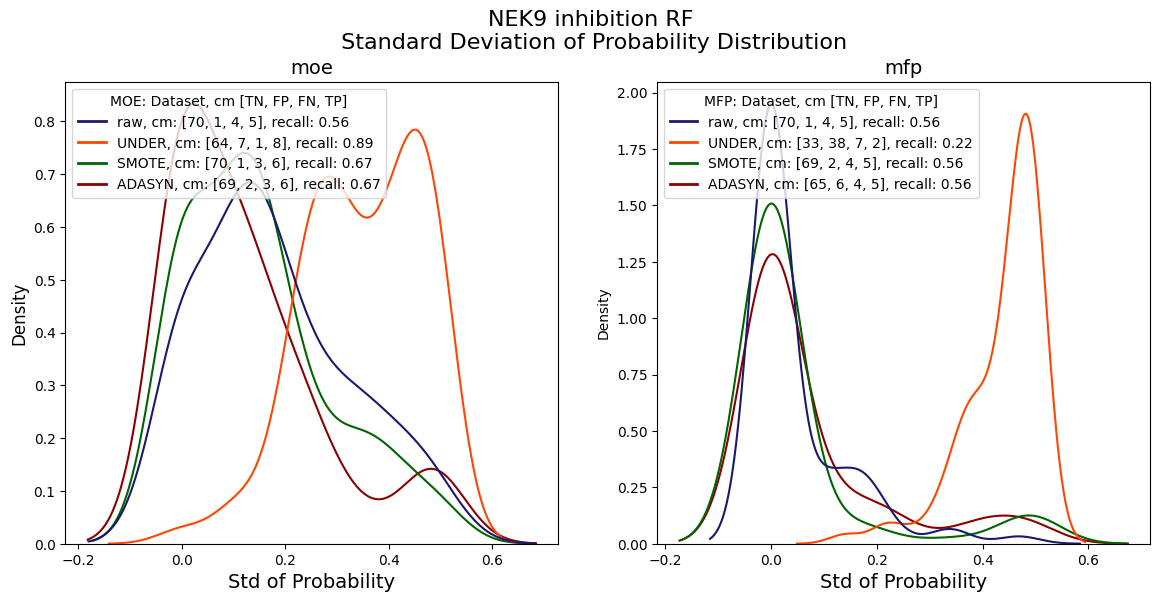

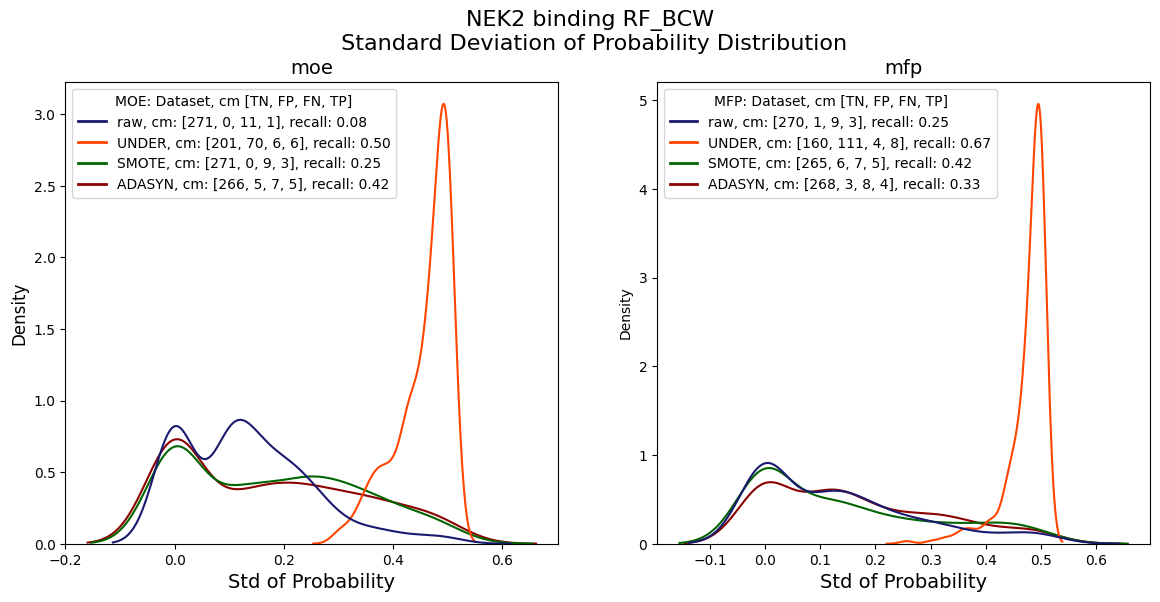

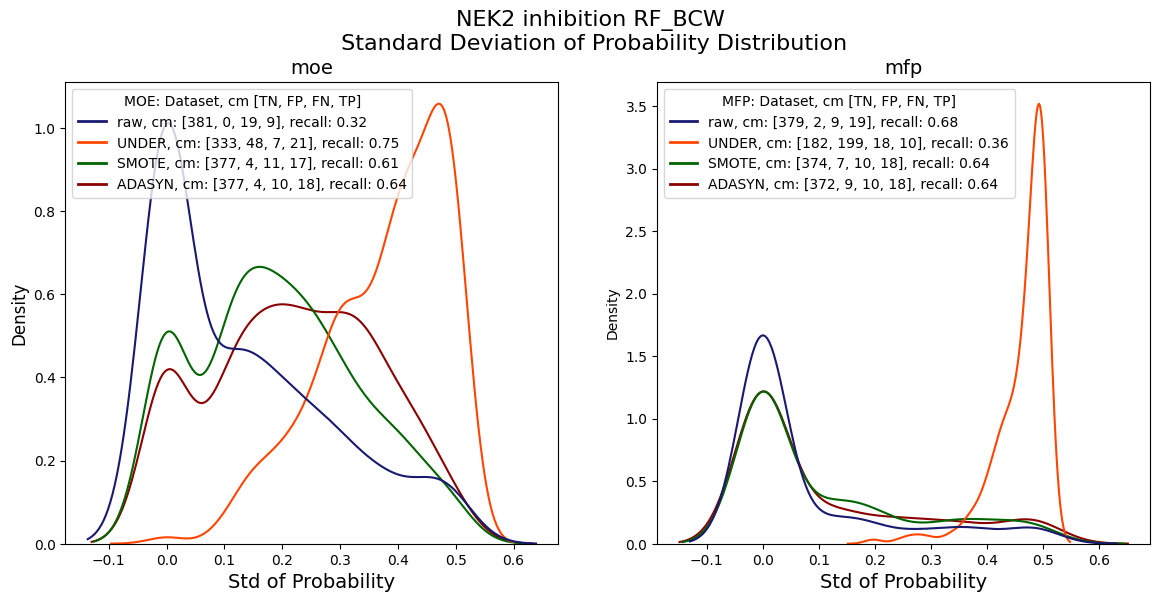

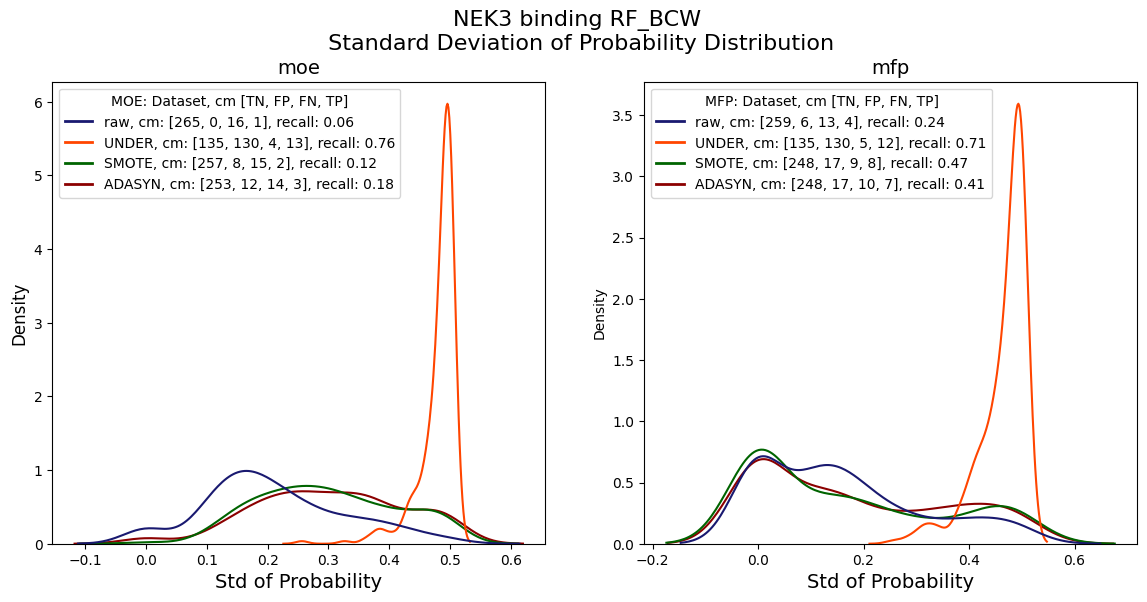

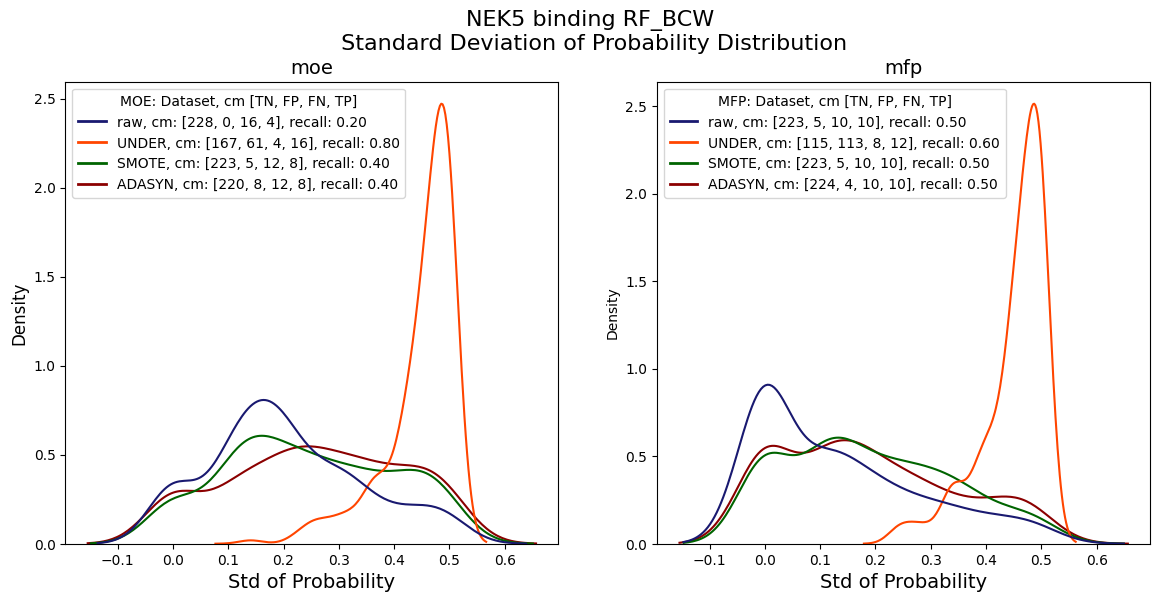

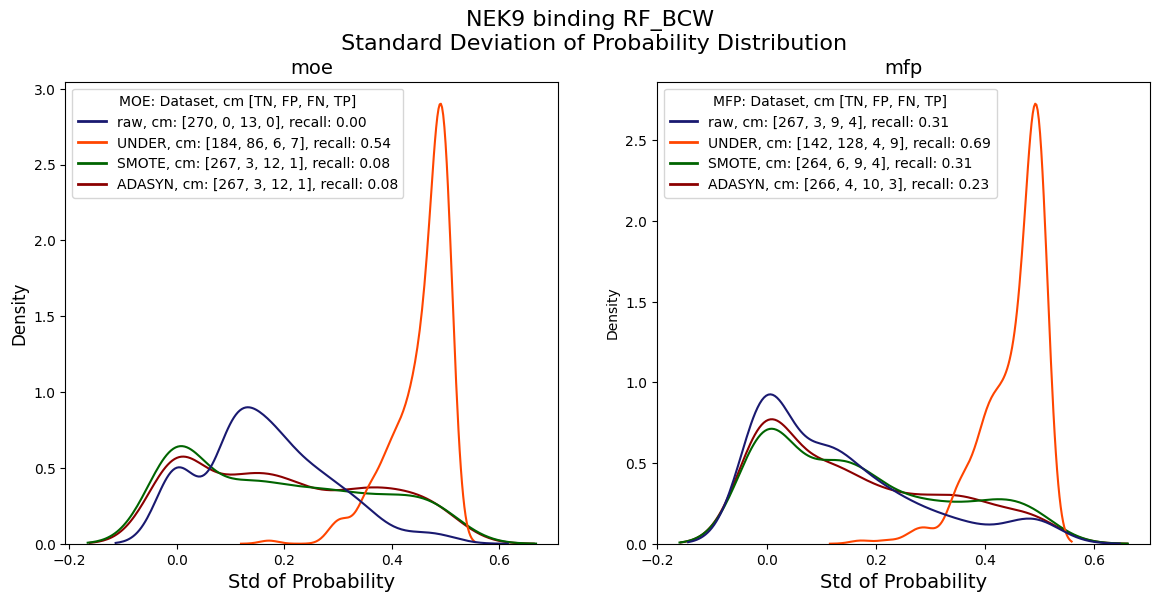

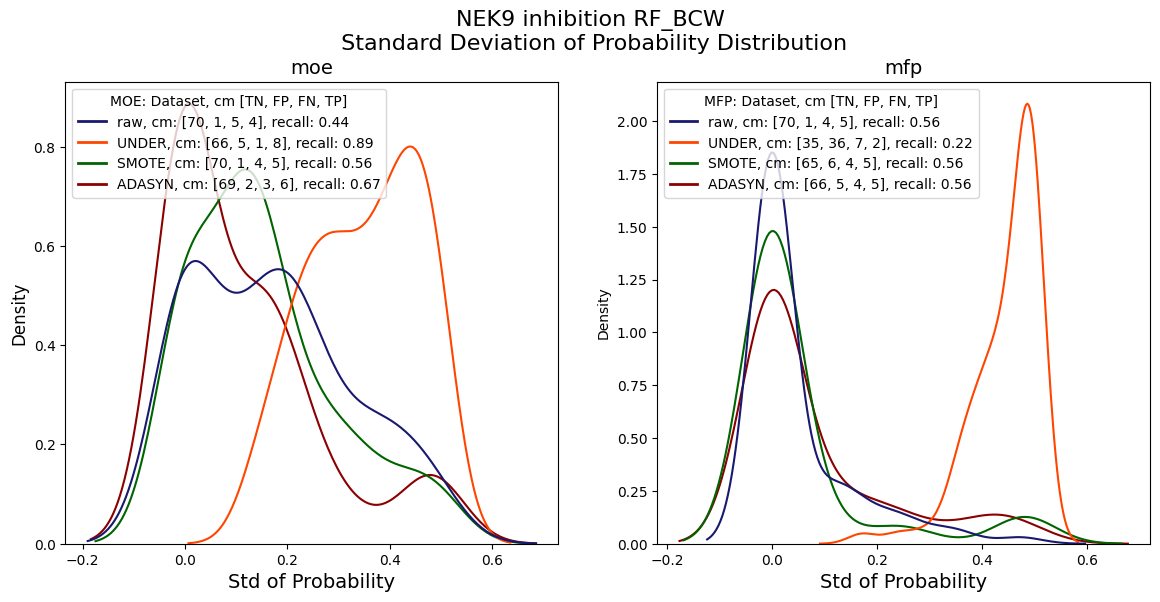

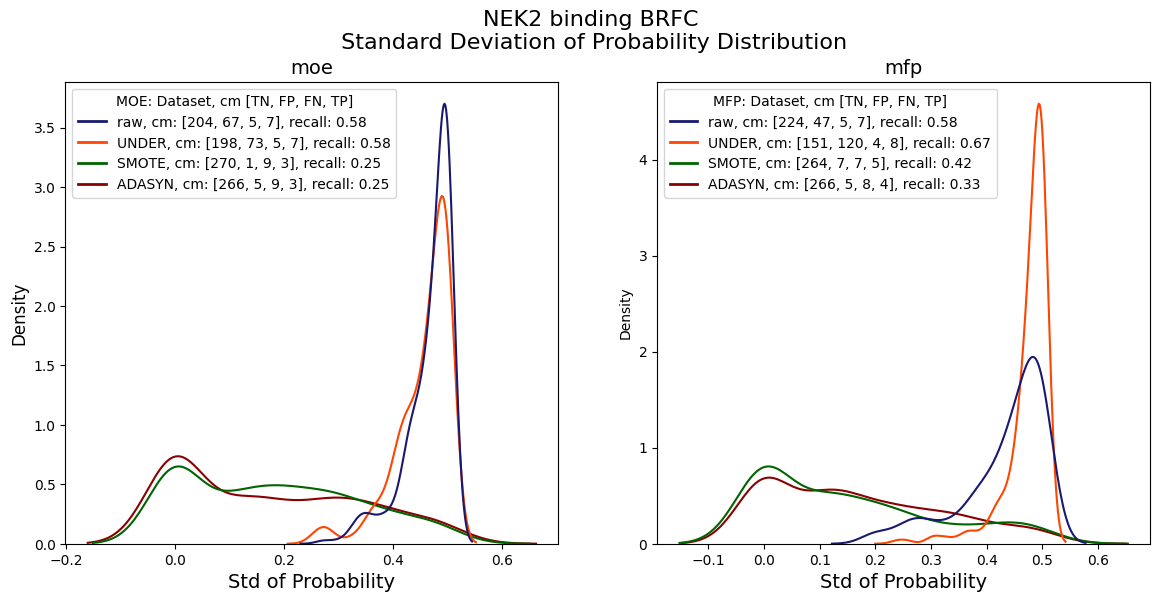

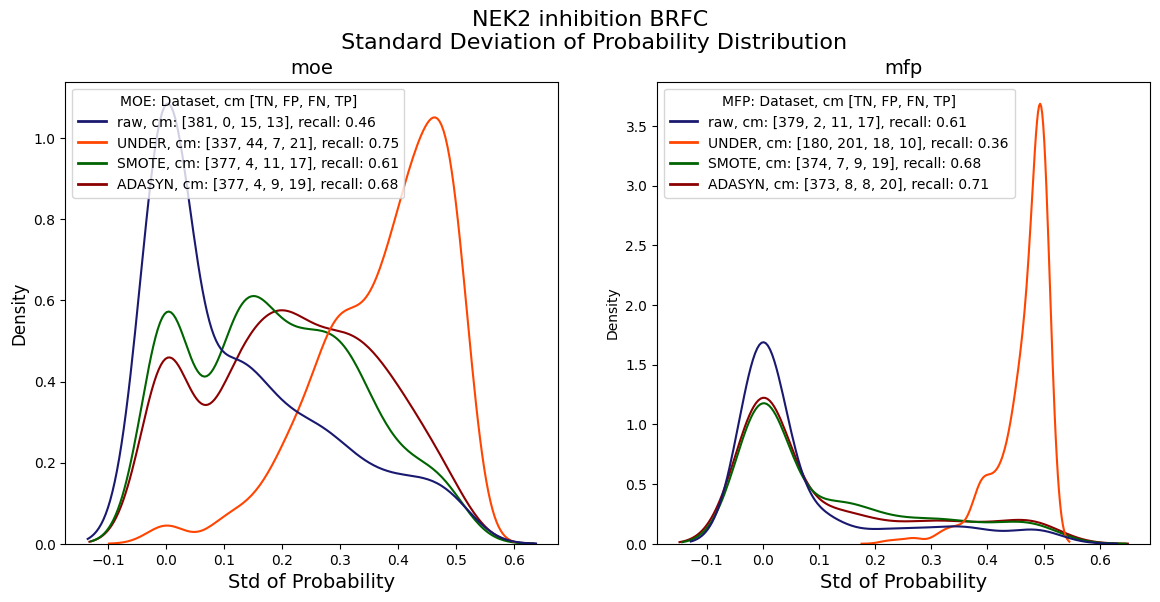

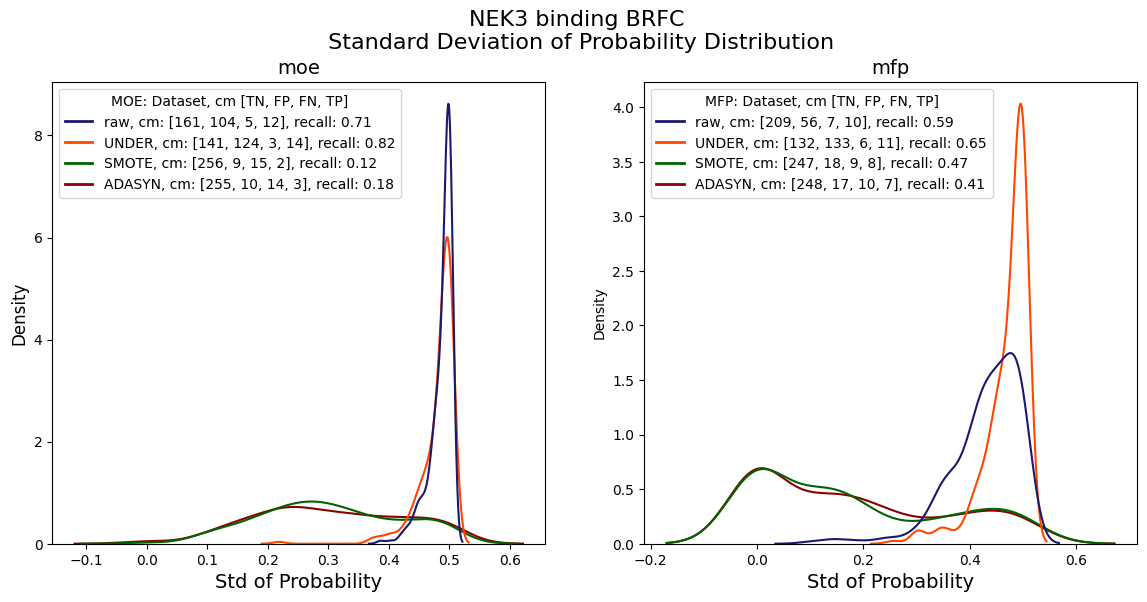

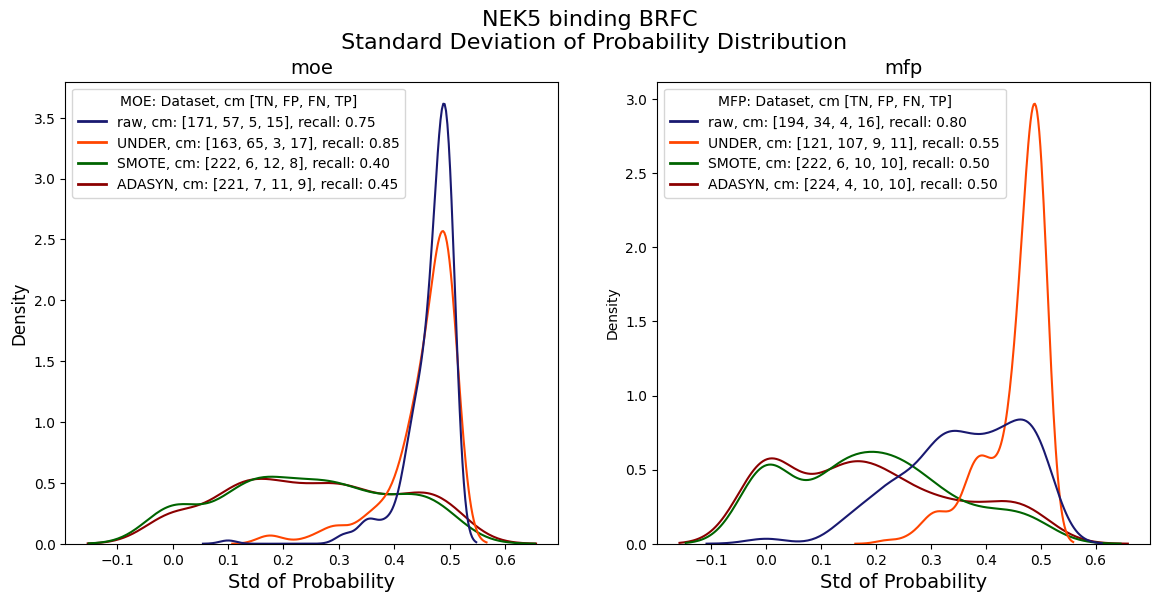

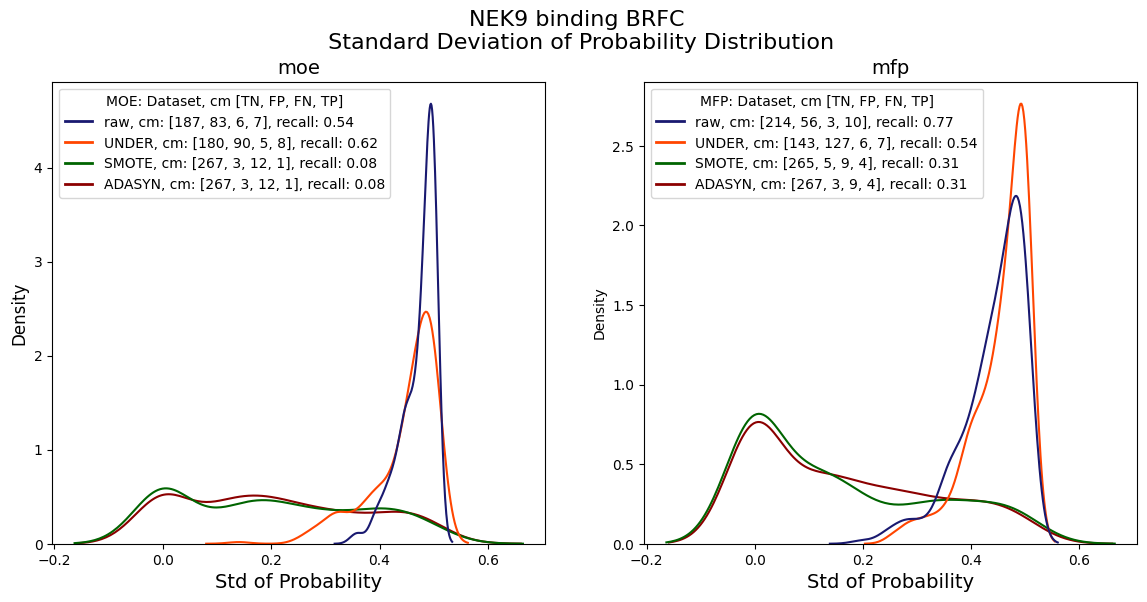

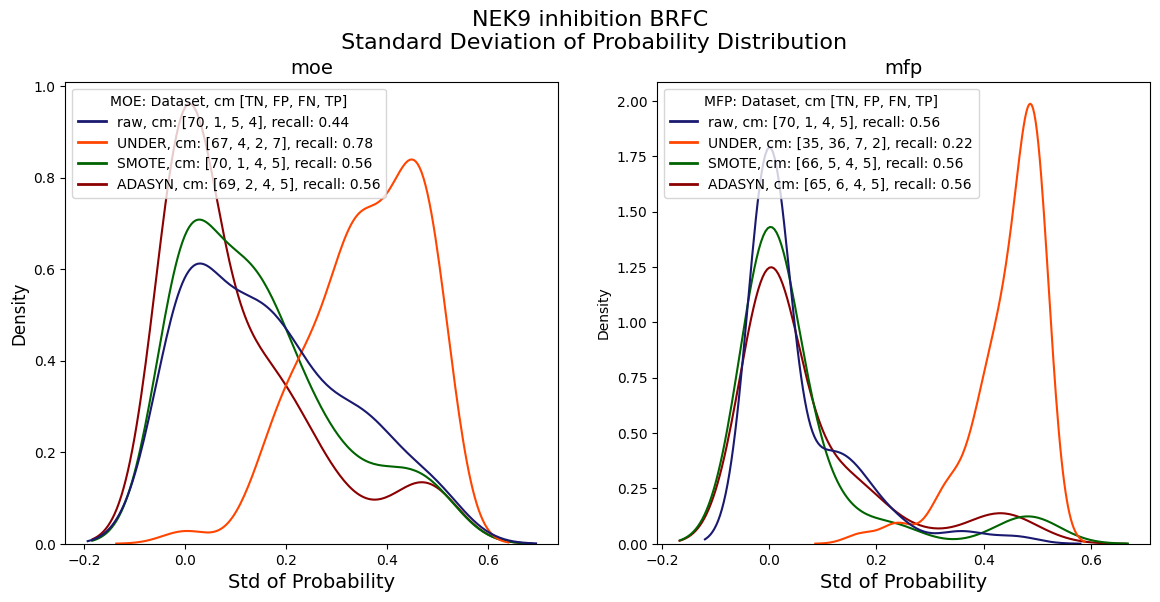

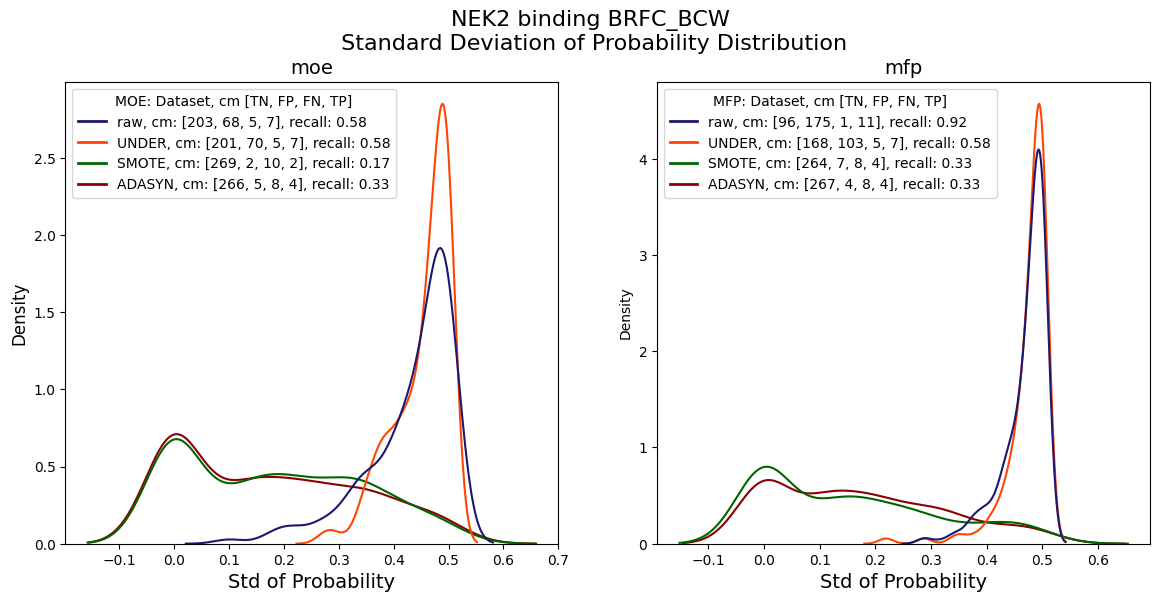

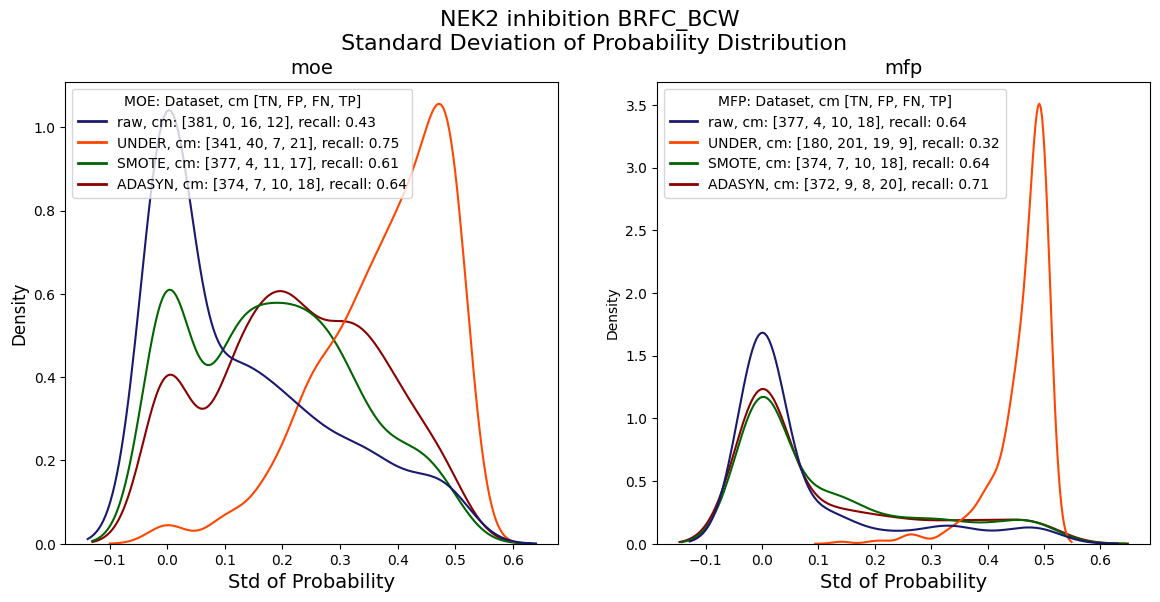

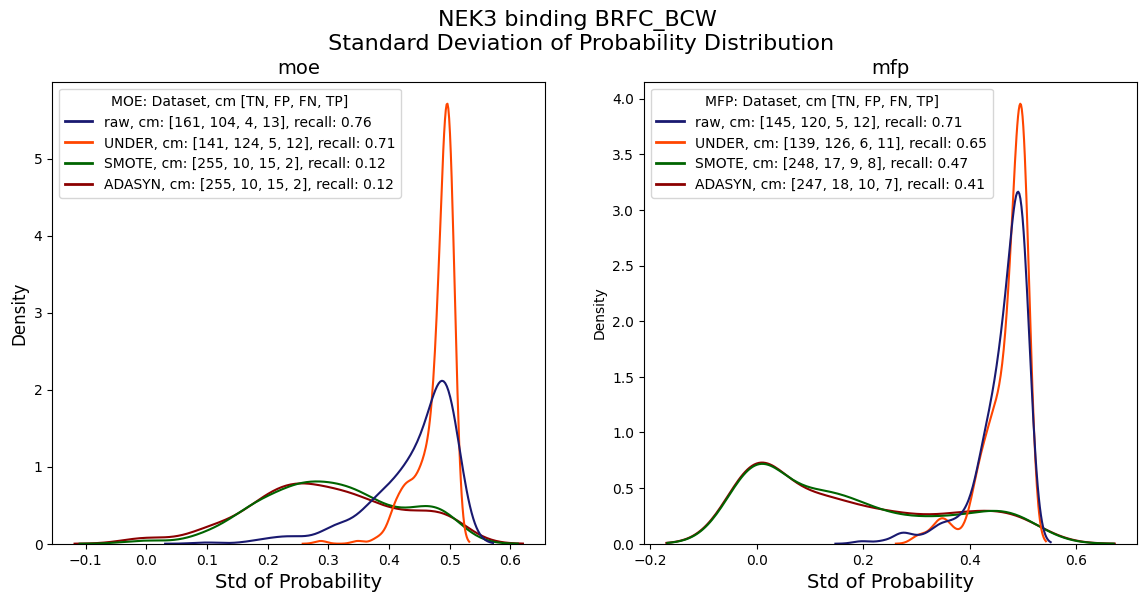

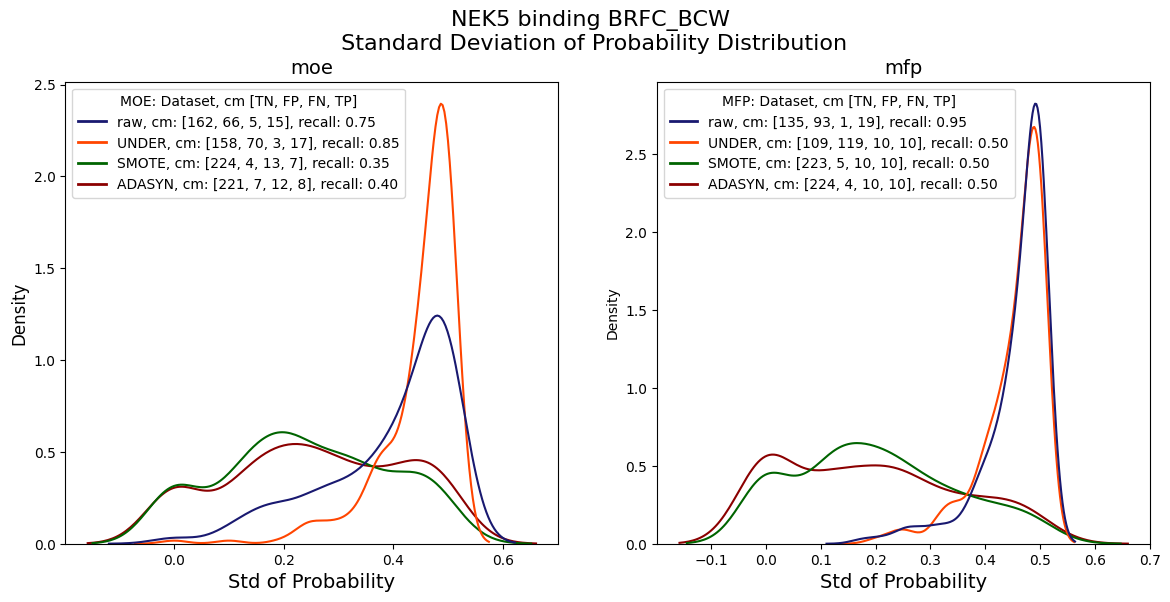

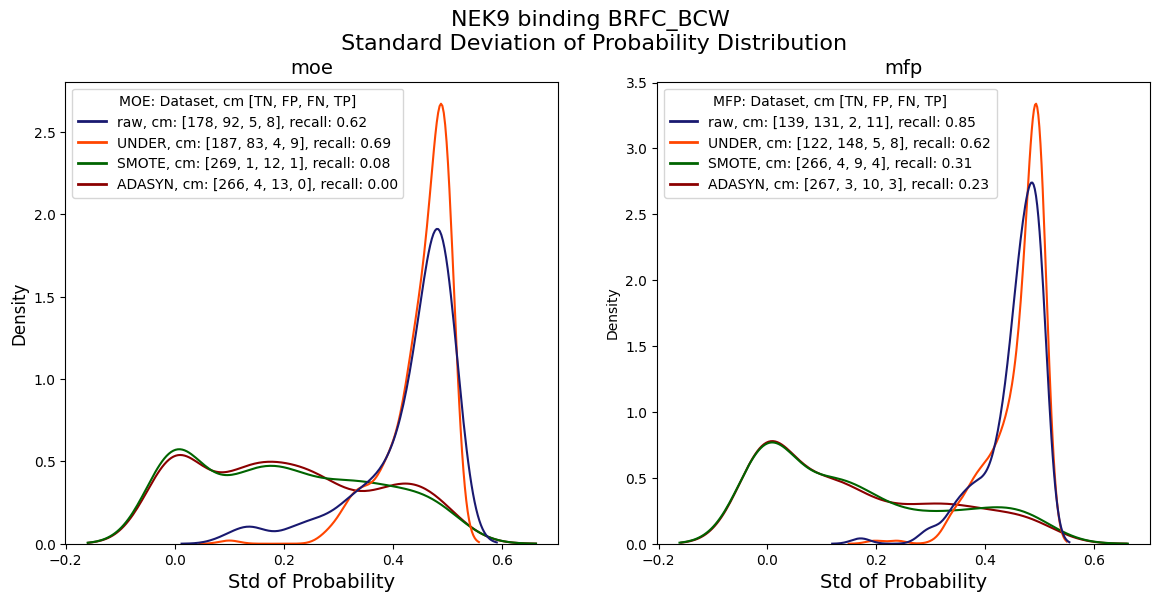

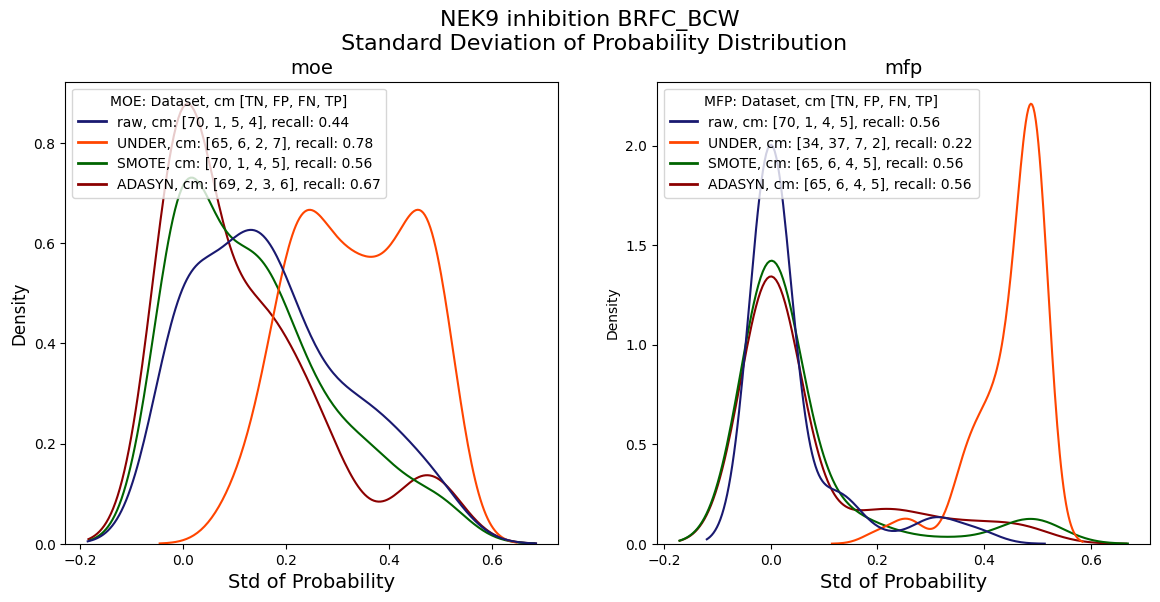

In [92]:
figure_path6 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_RF_std_prob/std_prob_distribution/moe_mfp/'
for rf in RF_types: 
    for nek in neks:
        dfs = [] 
        for feat in feat_types: 
            for samp in samplings: 
                df_root, bind_inhib = course_correct(nek)
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/{df_root}'
                nek_num = nek[3]
                full_df = pd.read_csv(f'{df_path}NEK{nek_num}_{bind_inhib}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                pred = pd.read_csv(f'{result_path}NEK{nek_num}_{bind_inhib}_{feat}_{samp}_{rf}_test.csv')
                stdprobs = pd.read_csv(f'{prob_path}NEK{nek_num}_{bind_inhib}_std_prob_{samp}_{rf}.csv')
                std0 = stdprobs[f'std0_{feat}'].to_numpy()
                std1 = stdprobs[f'std1_{feat}'].to_numpy()
                preds = pred['prediction']
                true_labels = pred['y'].to_numpy()
                cm = pred['cm'][0]
                df = pd.DataFrame({'prediction': preds, 'prediction_type': pred['prediction_type'], 'std0': std0, 'std1': std1, 'ADdist': test_dist, 'true_labels': true_labels, 'cm': cm})
                if (samp == 'scaled'): 
                    samp = 'raw'
                df['NEK'] = nek
                df['feat_type'] = feat
                df['strategy'] = samp 
                df['RF_type'] = rf
                df['cm'] = cm
                df['recall'] = pred['recall'].iloc[0]
                
                dfs.append(df) 
                if (samp == 'raw'): 
                    samp = 'scaled'
        filename = f'NEK{nek_num}_{bind_inhib}_{rf}_prob_std_dist'
        title = f'NEK{nek_num} {bind_inhib} {rf}\n Standard Deviation of Probability Distribution' 
        plot_std_dist_moemfp2(dfs, title, figure_path6, filename)

In [14]:
def gather_plot_data(df): 
    predictions = df['prediction'] 
    true_labels = df['true_labels'] 
    std1 = df['std1'] 
    std0 =df['std0'] 
    ad_dist = df['ADdist'] 

    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg] 
    
    data = {
        'std of probabilities': np.concatenate([tp_std1,tn_std0,fp_std1, fn_std1]),
        'prediction_type': ['TP'] * len(true_pos) + ['TN'] * len(true_neg) + ['FP'] * len(false_pos) + ['FN'] * len(false_neg),
        'ADdist': np.concatenate([tp_ad, tn_ad, fp_ad,fn_ad]) 
    }
    
    df2=pd.DataFrame(data) 
    df2['NEK'] = df['NEK'].iloc[0]
    df2['feat_type'] = df['feat_type'].iloc[0]
    df2['strategy']  = df['strategy'].iloc[0]
    df2['RF_type']  = df['RF_type'].iloc[0]
    df2['cm'] = df['cm'].iloc[0]
    df2['recall'] = df['recall'].iloc[0]

    return df2



In [15]:
def course_correct(this_nek): 
    if this_nek == 'NEK2_binding': 
        df_root = 'NEK2/bind/'
        bind_or_inhib = 'binding'
        return df_root, bind_or_inhib
    elif this_nek == 'NEK2_inhibition': 
        df_root = 'NEK2/inhib/'
        bind_or_inhib = 'inhibition'
        return df_root, bind_or_inhib
    elif this_nek == 'NEK3_binding': 
        df_root = 'NEK3/bind/'
        bind_or_inhib = 'binding'
        return df_root, bind_or_inhib
    elif this_nek == 'NEK5_binding': 
        df_root = 'NEK5/bind/'
        bind_or_inhib = 'binding'
        return df_root, bind_or_inhib
    elif this_nek == 'NEK9_binding': 
        df_root = 'NEK9/bind/'
        bind_or_inhib = 'binding'
        return df_root, bind_or_inhib
    elif this_nek == 'NEK9_inhibition': 
        df_root = 'NEK9/inhib/'
        bind_or_inhib = 'inhibition'
        return df_root, bind_or_inhib
    else: 
        return 'error', 'error'



# Paired Down

In [16]:
special_palette2 = {'raw_RF': 'tab:red', 'raw_RF_BCW': 'purple', 
                   'raw_BRFC': 'limegreen', 'raw_BRFC_BCW': '#35605A', 
                   'UNDER_RF': '#42BFDD', 'ADASYN_RF': 'yellow'}
def plot_std_dist_moemfp_reg_legend(dfs,  title=None, figure_path=None, filename=None):
    all_moe_dfs=[] 
    all_mfp_dfs = []
    for df in dfs:
        this_df = gather_plot_data(df)
        this_moe_df = this_df[this_df['feat_type'] == 'moe']
        all_moe_dfs.append(this_moe_df)
        this_mfp_df = this_df[this_df['feat_type'] == 'mfp']
        all_mfp_dfs.append(this_mfp_df)
    
    full_moe_df = pd.concat(all_moe_dfs)
    full_mfp_df = pd.concat(all_mfp_dfs)

    rf_moe_raw = full_moe_df[(full_moe_df['strategy'] == 'raw') & (full_moe_df['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
    rf_moe_other = full_moe_df[(full_moe_df['RF_type'] == 'RF') & (full_moe_df['strategy'].isin(['UNDER', 'ADASYN']))]  
    moe_final = pd.concat([rf_moe_raw, rf_moe_other])
    moe_final['strategy'] = moe_final['strategy'].astype(str) +'_'+moe_final['RF_type']

    rf_mfp_raw = full_mfp_df[(full_mfp_df['strategy'] == 'raw') & (full_mfp_df['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
    rf_mfp_other = full_mfp_df[(full_mfp_df['RF_type'] == 'RF') & (full_mfp_df['strategy'].isin(['UNDER', 'ADASYN']))]  
    mfp_final = pd.concat([rf_mfp_raw, rf_mfp_other])
    mfp_final['strategy'] = mfp_final['strategy'].astype(str) +'_'+mfp_final['RF_type']

    fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=False)
    sns.kdeplot(data=moe_final, x='std of probabilities', hue='strategy',
                palette=special_palette2, ax=axs[0])
    axs[0].set_title('MOE', fontsize=16)
    sns.kdeplot(data=mfp_final, x='std of probabilities', hue='strategy',
                palette=special_palette2, ax=axs[1])
    axs[1].set_title('MFP', fontsize=16)
    for i, val in enumerate(axs): 
        axs[i].set_xlabel('Std of Probability', fontsize=16)
        axs[i].set_ylabel('Density', fontsize=16)
        # axs[i].get_legend().remove()
        axs[i].set(xlim=(-0.2, .75))
        axs[i].set(ylim=(0, 6))
        
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),fontsize=16)

    
    if title is not None: 
        plt.suptitle(title, x=0.5, y=1.05, fontsize=20)
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{filename}.png',bbox_inches='tight')
    
    plt.show();

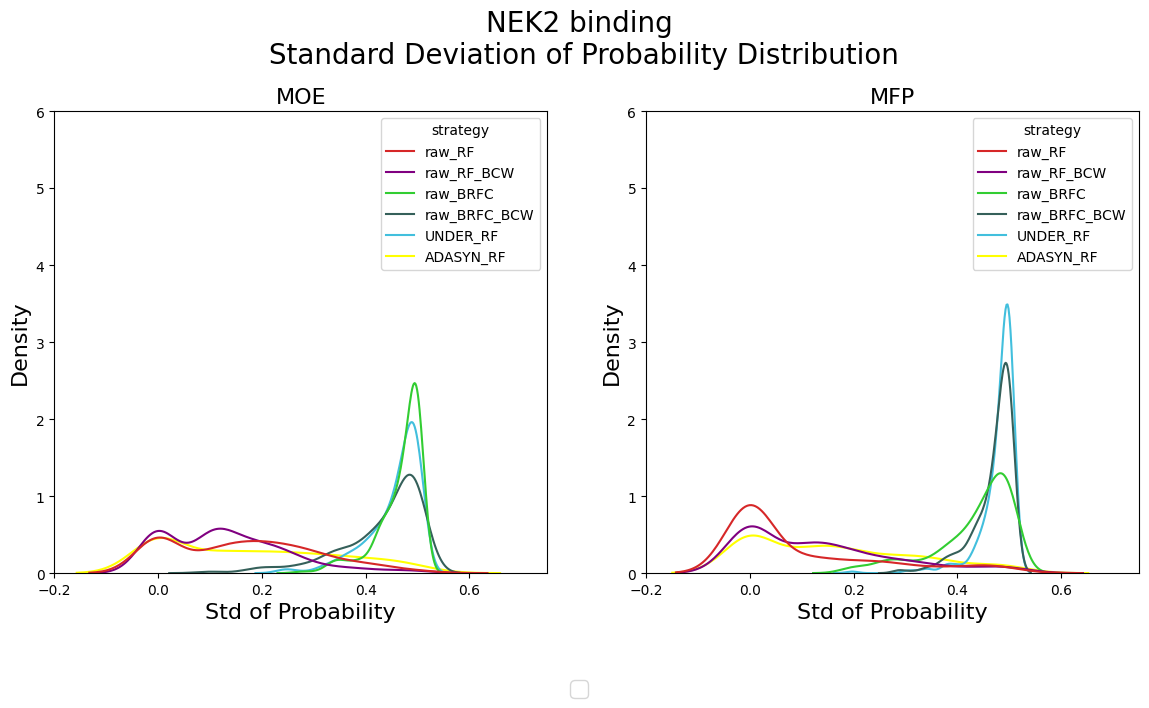

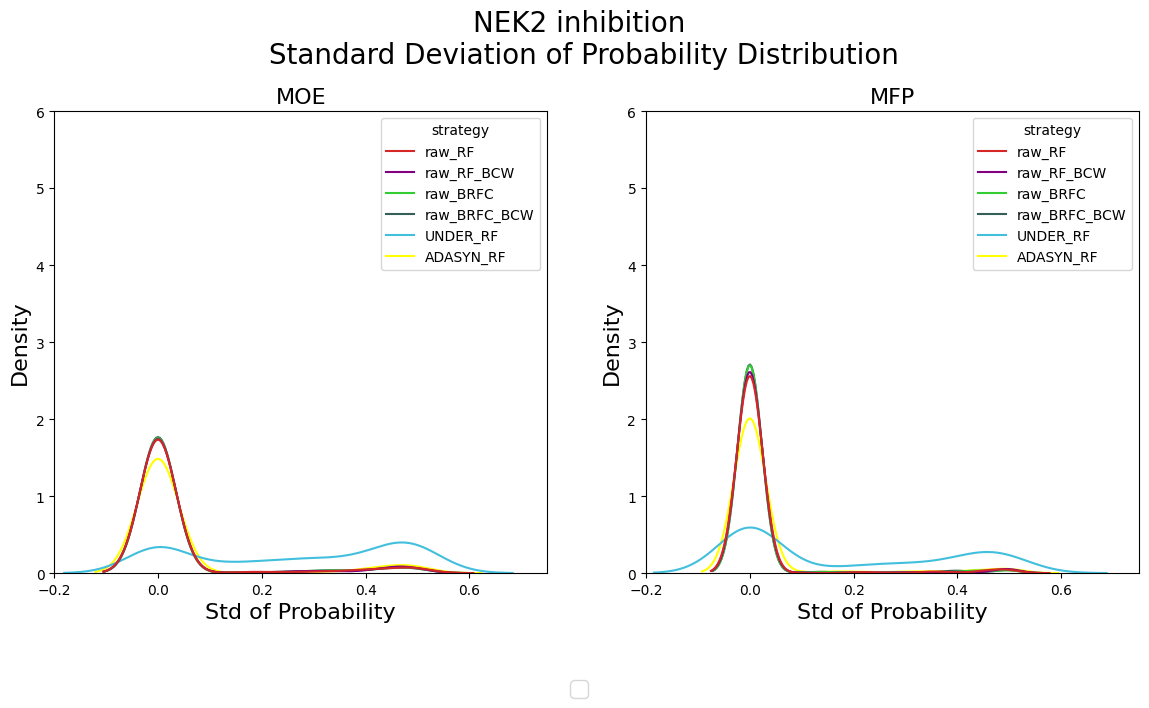

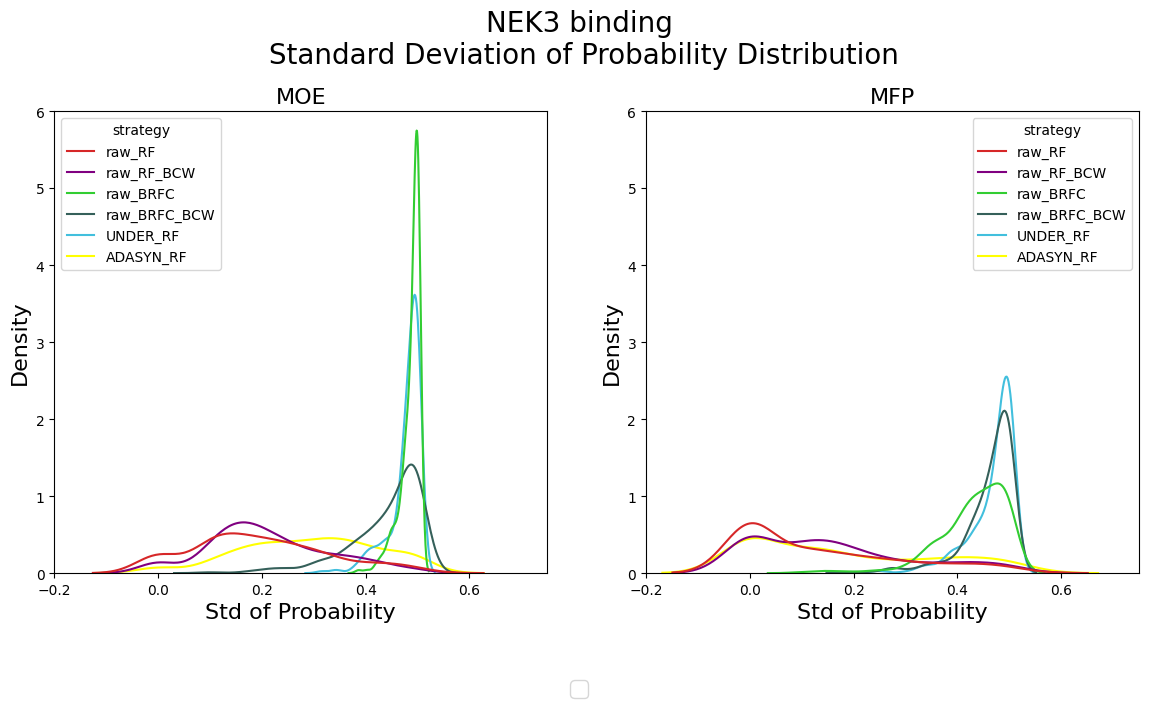

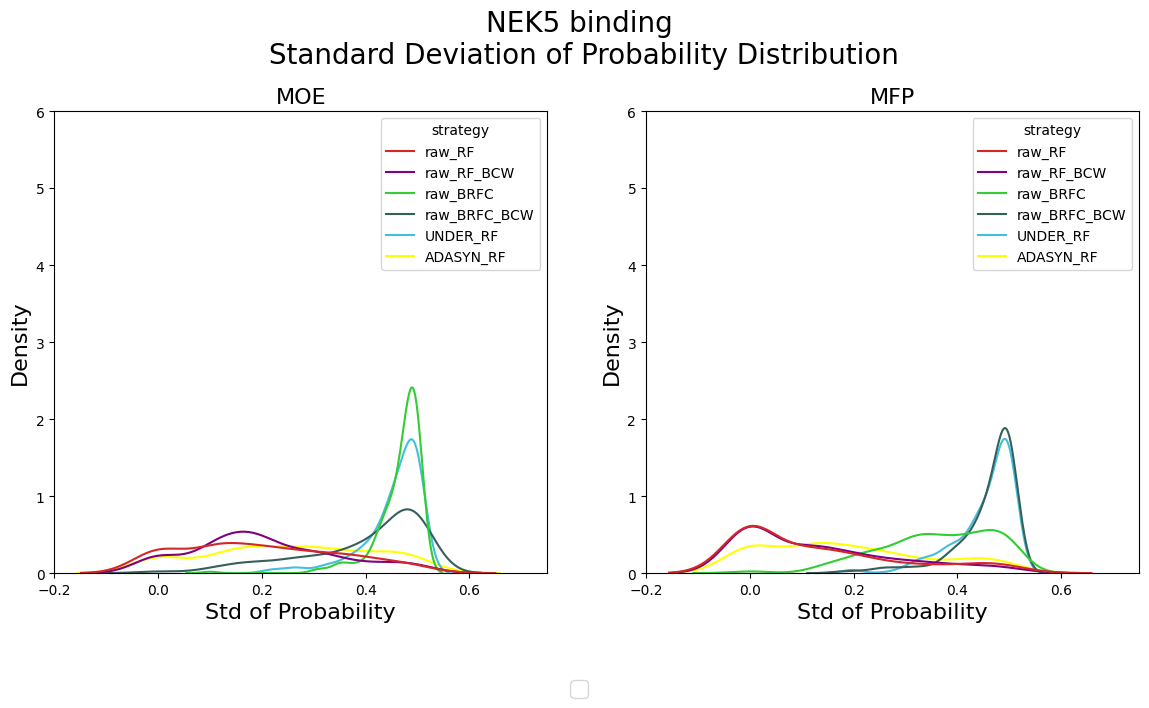

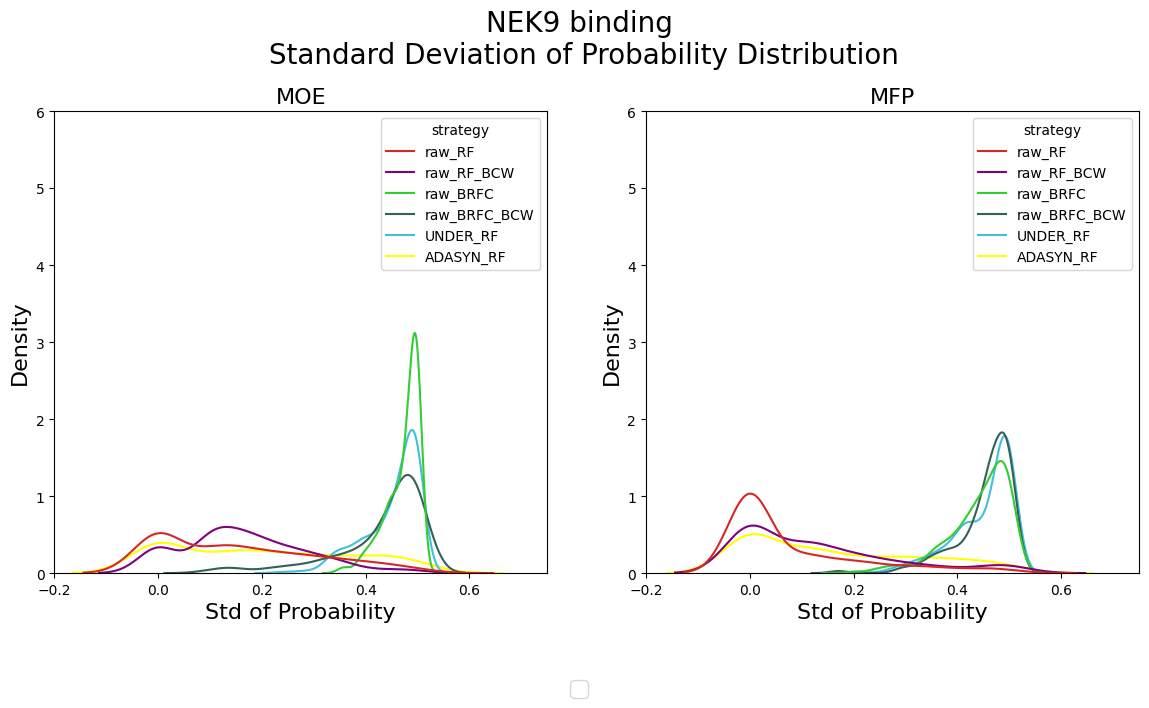

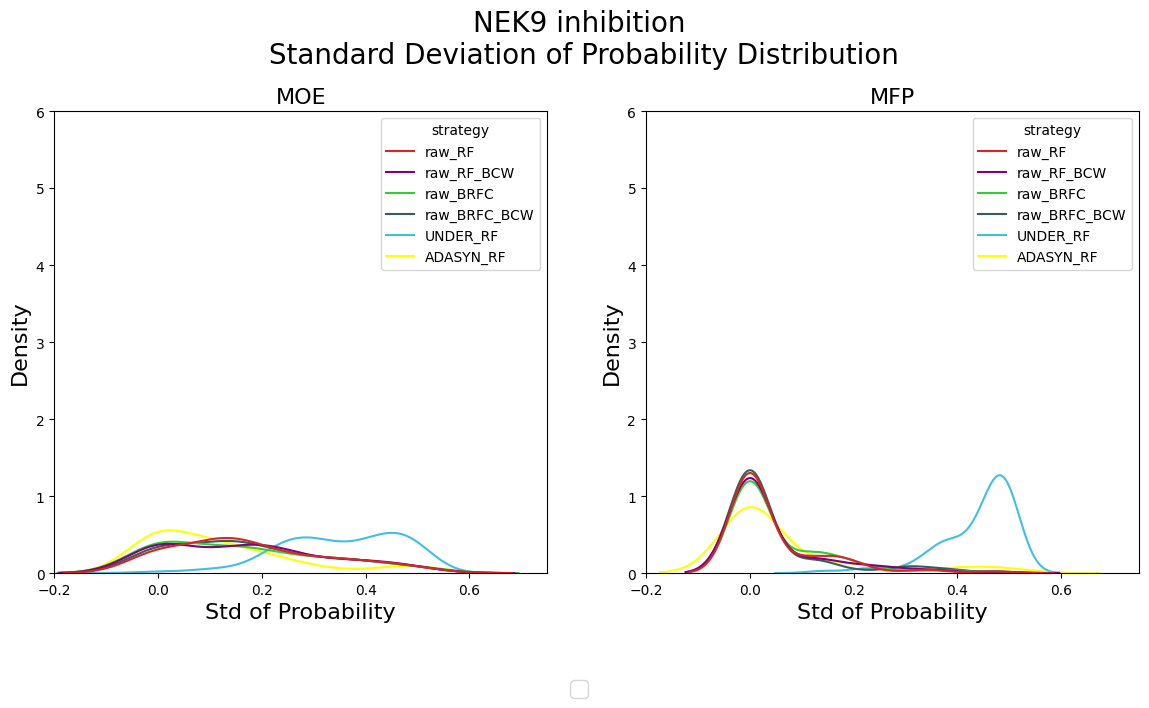

In [17]:
figure_path9 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/AD/figures/AD_RF_std_prob/std_prob_distribution/paired_down/basic_legend/'
for nek in neks:
    dfs = [] 
    for feat in ['moe', 'mfp']: 
        for rf in RF_types:
            for samp in samplings: 
                df_root, bind_inhib = course_correct(nek)
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/{df_root}'
                nek_num = nek[3]
                full_df = pd.read_csv(f'{df_path}NEK{nek_num}_{bind_inhib}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                pred = pd.read_csv(f'{result_path}NEK{nek_num}_{bind_inhib}_{feat}_{samp}_{rf}_test.csv')
                stdprobs = pd.read_csv(f'{prob_path}NEK{nek_num}_{bind_inhib}_std_prob_{samp}_{rf}.csv')
                std0 = stdprobs[f'std0_{feat}'].to_numpy()
                std1 = stdprobs[f'std1_{feat}'].to_numpy()
                preds = pred['prediction']
                true_labels = pred['y'].to_numpy()
                cm = pred['cm'][0]
                rf_types = pred['RF_type'].to_numpy()
                df = pd.DataFrame({'prediction': preds, 'prediction_type': pred['prediction_type'], 'std0': std0, 'std1': std1, 'ADdist': test_dist, 'true_labels': true_labels, 'cm': cm, 'RF_type': rf_types})
                if (samp == 'scaled'): 
                    samp = 'raw'
                df['NEK'] = nek
                df['feat_type'] = feat
                df['strategy'] = samp 
                df['recall'] = pred['recall'].iloc[0]
                
                dfs.append(df) 
    
                if (samp == 'raw'): 
                    samp = 'scaled'
    filename = f'{nek}_{feat}_prob_std_dist'
    title = f'NEK{nek_num} {bind_inhib}\n Standard Deviation of Probability Distribution' 
    plot_std_dist_moemfp_reg_legend(dfs, title)



# Paired down with recall legend 


In [18]:
def plot_std_dist_moemfp3(dfs, moemfp, title=None, figure_path=None, filename=None):
    all_dfs=[] 
    strategy_cm_map = {}
    recall_map = {}
    for df in dfs:
        this_df = gather_plot_data(df)
        this_feat_df = this_df[this_df['feat_type'] == moemfp]
        all_dfs.append(this_feat_df)
    print(strategy_cm_map)
    full_df = pd.concat(all_dfs)

    rf_raw = full_df[(full_df['strategy'] == 'raw') & (full_df['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
    rf_other = full_df[(full_df['RF_type'] == 'RF') & (full_df['strategy'].isin(['UNDER', 'ADASYN']))]  
    rf_final = pd.concat([rf_raw, rf_other])
    rf_final['strategy'] = rf_final['strategy'].astype(str) +'_'+rf_final['RF_type']
    print(rf_final['strategy'].unique())
    for samp in rf_final['strategy'].unique(): 
        samp_df= rf_final[rf_final['strategy'] == samp]
        strategy = samp_df['strategy'].iloc[0]
        cm_value =samp_df['cm'].iloc[0] 
        cm_value_str = str(cm_value)
        recall_map[strategy] = f"{samp_df['recall'].iloc[0]:.2f}"
        strategy_cm_map[strategy] =cm_value_str
        
    
    display(rf_final) 

    
    # fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    plt.figure(figsize=(7, 6))

    sns.kdeplot(data=rf_final, x='std of probabilities', hue='strategy',
                palette=special_palette2, hue_order=strategy_order)
    plt.title(moemfp, fontsize=14)
    plt.xlabel('Std of Probability', fontsize=14)
    plt.ylabel('Density', fontsize=12)

    labels = []
    handles = []
    for samp in strategy_order:
        if samp in strategy_cm_map:
            label = f'{samp}, cm: {strategy_cm_map[samp]}, recall: {recall_map[samp]}'
            color = special_palette2[samp]
            labels.append(label)
            handles.append(Line2D([0], [0], color=color, lw=2))
    plt.legend(handles, labels, title=f'{moemfp}: Dataset, cm [TN, FP, FN, TP]', loc='upper left', bbox_to_anchor=(1.05, .7))
  
    if title is not None: 
        plt.suptitle(title, x=0.5, y=1, fontsize=16)
    
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{filename}.png',bbox_inches='tight')
    
    plt.show()

